In [13]:
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import os, boto3, io

BUCKET = os.getenv("BUCKET")
PROCESSED_DATA_FOLDER = os.getenv("PROCESSED_DATA_FOLDER")
PATCH = "patch_15_6/"
CHAMPION_X_ROLE = "champion_x_role_sample.csv"

pd.set_option("display.max_columns", None)

champion_x_role_df = pd.read_csv(CHAMPION_X_ROLE, index_col="champion_name")
display(champion_x_role_df)

,champion_id,team_position,total_games_played_in_role,total_games_per_champion,avg_kills,avg_deaths,avg_deaths_by_enemy_champs,avg_assists,avg_kill_participation,avg_takedowns,total_wins,pct_of_games_with_highest_damage_dealt,avg_pct_damage_dealt_in_team,average_damage_per_minute,avg_damage_dealt_to_champions,avg_total_damage_dealt,avg_magic_damage_dealt_to_champions,avg_total_magic_damage_dealt,avg_physical_damage_dealt_to_champions,avg_total_physical_damage_dealt,avg_true_damage_dealt_to_champions,avg_total_true_damage_dealt,avg_largest_critical_strike,avg_pct_damage_taken_in_team,avg_damage_taken,avg_magic_damage_taken,avg_physical_damage_taken,avg_true_damage_taken,avg_damage_self_mitigated,avg_times_killed_champ_took_full_team_damage_and_survived,avg_times_survived_single_digit_hp,avg_times_survived_three_immobilizes_in_fight,avg_times_took_large_damage_survived,pct_of_games_with_highest_crowd_control_score,avg_time_ccing_others,avg_times_applied_cc_on_others,avg_enemy_champion_immobilizations,avg_total_healing,avg_heals_on_teammate,avg_total_units_healed,avg_dmg_shielded_on_team,avg_effective_heal_and_shield,total_games_completed_supp_quest_first,avg_supp_quest_completion_time,avg_longest_time_spent_alive,avg_time_spent_dead,avg_spell1_casts,avg_spell2_casts,avg_spell3_casts,avg_spell4_casts,avg_ability_uses,avg_times_dodged_skillshot_in_small_window,avg_skillshots_dodged,avg_skillshots_landed_early_game,avg_skillshots_hit,avg_times_immobilize_and_kill_with_ally,avg_times_got_kill_after_hidden_with_ally,avg_times_pick_kill_with_ally,avg_times_knock_enemy_into_team_and_kill,avg_kills_near_enemy_turret,avg_kills_under_own_turret,avg_multikills_after_aggressive_flash,avg_outnumbered_kills,avg_times_outnumbered_nexus_kill,avg_times_quick_cleanse,avg_quick_solo_kills,avg_solo_kills,avg_takedowns_after_gaining_lvl_advantage,avg_kills_on_other_lanes_early_as_laner,avg_times_save_ally_from_death,avg_takedowns_in_alcove,pct_of_games_first_blood_kill,pct_of_games_first_blood_assist,avg_takedowns_before_jungle_camps_spawn,avg_first_takedown_time,avg_summoner_spell1_casts_per_game,avg_summoner_spell2_casts_per_game,pct_of_matches_with_ghost,pct_of_matches_with_cleanse,pct_of_matches_with_smite,pct_of_matches_with_teleport,pct_of_matches_with_exhaust,pct_of_matches_with_ignite,pct_of_matches_with_heal,pct_of_matches_with_flash,pct_of_matches_with_barrier,avg_champ_exp_at_game_end,avg_champ_level_at_game_end,avg_gold_earned_per_game,avg_gold_per_minute,avg_gold_spent,avg_bounty_lvl,avg_bounty_gold,pct_of_games_with_early_lane_phase_gold_exp_adv,pct_of_games_with_lanephase_gold_exp_adv,avg_max_level_lead_over_lane_opp,avg_minions_killed,avg_minions_killed_by_10_mins,avg_max_cs_lead_over_lane_opponent,avg_consumables_purchased,avg_number_of_items_purchased,total_games_fastest_item_completion,avg_items_completed,avg_ally_jungle_minions_killed,avg_enemy_jungle_minions_killed,avg_enemy_jungle_cs_differential_early,avg_jungle_monsters_cs,avg_buffs_stolen,avg_initial_buff_count,avg_epic_monster_kills_within_30s_of_spawn,avg_initial_crab_count,avg_crabs_per_game,avg_jg_cs_before_10m,avg_jungler_kills_early_jungle,avg_jungler_early_kills_on_laners,avg_times_had_early_takedowns_in_all_lanes_as_laner,avg_jungler_takedowns_near_damaged_epic_monsters,avg_kills_with_help_from_epic_monster,avg_vision_score,avg_vision_score_per_min,avg_vision_score_advantage_over_lane_opponent,avg_stealth_wards_placed,avg_wards_placed,avg_wards_guarded,avg_control_wards_placed,avg_control_ward_time_coverage_in_river_or_enemy_half,avg_unseen_recalls,pct_of_games_with_highest_wards_killed,avg_wards_killed,avg_ward_takedowns,avg_ward_takedowns_before_20m,avg_times_2_wards_killed_with_1_sweeper,avg_control_wards_bought,pct_of_games_team_took_first_baron,avg_earliest_baron_by_team_time,pct_of_games_team_took_first_dragon,pct_of_games_team_took_first_inhib,pct_of_games_team_took_first_herald,pct_of_games_team_took_first_turret,avg_baron_kills_by_team,avg_herald_kills_by_te

In [14]:
df = champion_x_role_df
# Creating features
df["total_role_games"] = df.groupby("team_position")["total_games_played_in_role"].transform("sum")
# Popularity metrics
df["popularity_in_role"] = df["total_games_played_in_role"]/df["total_role_games"]
df["role_popularity_for_champion"] = df["total_games_played_in_role"]/df["total_games_per_champion"]
# Damage done metrics
df["pct_magic_damage"] = df["avg_magic_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
df["pct_physical_damage"] = df["avg_physical_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
df["pct_true_damage"] = df["avg_true_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
# Damage taken metrics
df["avg_damage_taken_per_death"] = df["avg_damage_taken"]/df["avg_deaths"]
# JUNGLE (REVISIT UPSTREAM)
df["avg_kills_on_other_lanes_early_as_laner"] = np.where( 
    df["team_position"] != "JUNGLE", 
    df["avg_kills_on_other_lanes_early_as_laner"], # As a laner, in a single game, get kills before 10 minutes outside your lane (anyone but your lane opponent)
    pd.NA
)
df["avg_times_had_early_takedowns_in_all_lanes_as_laner"] = np.where( 
    df["team_position"] != "JUNGLE", 
    df["avg_times_had_early_takedowns_in_all_lanes_as_laner"], # As a laner, in a single game, get kills before 10 minutes outside your lane (anyone but your lane opponent)
    pd.NA
)
df["avg_kills_early_jungle_as_jungler"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_jungler_kills_early_jungle"], # As jungler, get kills on the enemy jungler in their own jungle before 10 minutes
    pd.NA
)
df["avg_early_kills_on_laners_as_jungler"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_jungler_early_kills_on_laners"], # As jungler, get kills on top lane, mid lane, bot lane, or support players before 10 minutes
    pd.NA
)
df["pct_of_matches_with_jungle"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["pct_of_matches_with_jungle"], # As jungler, get kills on top lane, mid lane, bot lane, or support players before 10 minutes
    pd.NA
)
df["avg_enemy_jungle_cs_differential_early"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_enemy_jungle_cs_differential_early"], # As jungler, get kills on top lane, mid lane, bot lane, or support players before 10 minutes
    pd.NA
)
df["avg_supp_quest_completion_time"] = np.where(
    df["team_position"] == "UTILITY", 
    df["avg_supp_quest_completion_time"], # As a support, average support quest completion time
    pd.NA
)

# Structures
df["avg_individual_tower_assists"] = df["avg_individual_tower_takedowns"] - df["avg_individual_tower_kills"]

In [ ]:
labels = ["team_position", "champion_name"]

features_to_remove_jungle = []


laners_specific_features = ["avg_kills_on_other_lanes_early_as_laner", "avg_times_had_early_takedowns_in_all_lanes_as_laner",
                            "pct_of_games_indiv_killed_1st_tower", "pct_of_games_team_took_first_dragon", "pct_of_games_had_drag_takedown",
                            "pct_of_matches_with_mana", "avg_vision_score_advantage_over_lane_opponent",]

raw_clustering_features = [
    # Core 
    "avg_kills",
    "avg_deaths",
    "avg_assists",
    "avg_kill_participation",
    # Damage dealt
    "average_damage_per_minute",
    "avg_damage_dealt_to_champions",
    # Damage taken
    "avg_damage_self_mitigated",
    "avg_times_survived_three_immobilizes_in_fight",
    # CC
    "avg_time_ccing_others",
    "avg_times_applied_cc_on_others",
    "avg_enemy_champion_immobilizations",
    # Healing and shielding + Protecting
    "avg_total_healing",
    # Ability casts + Skillshots
    "avg_spell4_casts",
    "avg_ability_uses",
    "avg_skillshots_dodged",
    "avg_skillshots_landed_early_game",
    "avg_skillshots_hit",
    # Picks
    "avg_times_immobilize_and_kill_with_ally",
    "avg_times_pick_kill_with_ally",
    "avg_times_knock_enemy_into_team_and_kill",
    # Kill types
    "avg_kills_near_enemy_turret",
    "avg_outnumbered_kills",
    "avg_quick_solo_kills",
    "avg_solo_kills",
    # Laning kills
    "avg_takedowns_after_gaining_lvl_advantage",
    "avg_takedowns_in_alcove",
    "avg_first_takedown_time",
    # Summoner spells
    "pct_of_matches_with_ghost",
    "pct_of_matches_with_teleport",
    "pct_of_matches_with_ignite",
    # Gold and XP
    "avg_champ_exp_at_game_end",
    "avg_gold_earned_per_game",
    "avg_gold_per_minute",
    "pct_of_games_with_early_lane_phase_gold_exp_adv", # End the early laning phase (7 minutes) with 20% more gold and experience than your role opponent on Summoner's Rift
    "pct_of_games_with_lanephase_gold_exp_adv", # End the laning phase (14 minutes) with 20% more gold and experience than your role opponent 
    "avg_max_level_lead_over_lane_opp",
    # CS
    "avg_minions_killed",
    "avg_minions_killed_by_10_mins",
    "avg_cs_per_minute",
    "avg_max_cs_lead_over_lane_opponent",
    # Items
    "avg_number_of_items_purchased",
    "total_games_fastest_item_completion",
    # Jungle CS
    "avg_enemy_jungle_minions_killed",
    "avg_jungle_monsters_cs",
    "avg_buffs_stolen",
    "avg_initial_buff_count",
    "avg_epic_monster_kills_within_30s_of_spawn",
    "avg_initial_crab_count",
    "avg_crabs_per_game",
    "avg_enemy_jungle_cs_differential_early",
    # Vision Score
    "avg_vision_score_advantage_over_lane_opponent",
    "avg_ward_takedowns_before_20m",
    # Objs
    "pct_of_games_team_took_first_dragon",
    "avg_individual_rift_herald_takedowns",
    "avg_individual_dragon_takedowns",
    "avg_elder_dragon_kills_w_opposing_soul",
    "avg_indiv_dmg_dealt_to_buildings",
    "avg_indiv_turret_plates_taken",
    "pct_of_games_indiv_killed_1st_tower",
    "avg_individual_solo_towers_kills_late_game",
    "avg_individual_inhibitor_kills",
    "avg_individual_void_monster_kills",
    "pct_of_games_had_drag_takedown",
    # Game length
    "avg_time_played_per_game_minutes",
    # Multikills + Killing sprees
    "pct_of_games_first_blood_kill",
    "pct_of_games_first_blood_assist",
    "avg_number_of_multikills",
    "avg_quadrakills",
    "avg_multikills_with_one_spell",
    "avg_killing_sprees",
    # Mejais
    "percent_of_games_with_fully_stacked_mejais", ## new
    # Item tags
    "pct_of_matches_with_magic_resist",
    "pct_of_matches_with_jungle",
    "pct_of_matches_with_tenacity",
    "pct_of_matches_with_lane",
    "pct_of_matches_with_spell_block",
    "pct_of_matches_with_armor_penetration",
    "pct_of_matches_with_life_steal",
    "pct_of_matches_with_health",
    "pct_of_matches_with_attack_speed",
    "pct_of_matches_with_critical_strike",
    "pct_of_matches_with_ability_haste",
    "pct_of_matches_with_on_hit",
    "pct_of_matches_with_damage",
    "pct_of_matches_with_slow",
    "pct_of_matches_with_spell_damage",
    "pct_of_matches_with_spell_vamp",
    "pct_of_matches_with_aura",
    "pct_of_matches_with_magic_penetration",
    "pct_of_matches_with_cooldown_reduction",
    "pct_of_matches_with_armor",
    "pct_of_matches_with_health_regen",
    "pct_of_matches_with_mana",
    "pct_of_matches_with_nonboots_movement"
]


derived_clustering_features = [
    "popularity_in_role", 
    "role_popularity_for_champion",
    "pct_magic_damage",
    "pct_physical_damage",
    "pct_true_damage",
    "avg_damage_taken_per_death",
    "avg_effective_heal_and_shield",
    "avg_kills_on_other_lanes_early_as_laner",
    "avg_kills_early_jungle_as_jungler",
    "avg_early_kills_on_laners_as_jungler",
    "avg_times_had_early_takedowns_in_all_lanes_as_laner",
    "avg_control_ward_time_coverage_in_river_or_enemy_half",
    "avg_first_turret_kill_time_by_team",
    "avg_individual_tower_assists"
]

potential_features = [
    "pct_of_games_with_highest_damage_dealt",
    "avg_largest_critical_strike",
    "avg_pct_damage_taken_in_team",
    "avg_times_took_large_damage_survived", # Compare with 'avg_damage_taken_per_death' and likely choose 1
    "avg_supp_quest_completion_time",
    "pct_of_games_first_blood_kill",
    "pct_of_games_first_blood_assist",
    "avg_jungler_takedowns_near_damaged_epic_monsters",
    "avg_kills_with_help_from_epic_monster",
    "avg_control_wards_placed",
    "avg_ward_takedowns",
    "pct_of_games_team_took_first_baron",
    "pct_of_games_team_took_first_inhib",
    "avg_shortest_time_to_ace_from_1st_takedown",
    "pct_of_games_individual_killed_nexus",
    "avg_individual_dmg_dealt_to_objectives",
    "avg_individual_dragon_kills",
    "avg_objectives_stolen",
    "pct_of_games_had_drag_takedown_min_5_to_7",
    "pct_of_games_had_drag_takedown_min_7_to_11",
    "pct_of_games_had_drag_takedown_min_11_to_15",
    "pct_of_games_had_drag_takedown_min_15_plus",
    "avg_legendary_count",
    "avg_full_team_takedowns",
    "avg_pentakills",
    "avg_triplekills",
    "avg_doublekills",
    "avg_vision_score_per_min",
    "avg_pct_damage_dealt_in_team",
    "avg_heals_on_teammate",
    "avg_dmg_shielded_on_team",
    "avg_dragon_kills_by_team",
    "pct_of_games_team_took_first_herald",
    "pct_of_games_team_took_first_turret",
    "pct_of_games_individual_had_1st_turret_assist",
    "avg_individual_tower_kills",
    "pct_of_games_first_turret_taken_by_team",
    "avg_jg_cs_before_10m",
    "avg_times_save_ally_from_death",
]

low_value_features = [
    "total_wins",
    "avg_takedowns",
    "avg_total_damage_dealt",
    "avg_total_magic_damage_dealt",
    "avg_total_physical_damage_dealt",
    "avg_total_true_damage_dealt",
    "avg_damage_taken",
    "avg_magic_damage_taken",
    "avg_physical_damage_taken",
    "avg_true_damage_taken",
    "avg_times_survived_single_digit_hp",
    "pct_of_games_with_highest_crowd_control_score",
    "avg_total_units_healed",
    "total_games_completed_supp_quest_first",
    "avg_longest_time_spent_alive",
    "avg_time_spent_dead",
    "avg_spell1_casts",
    "avg_spell2_casts",
    "avg_spell3_casts",
    "avg_times_dodged_skillshot_in_small_window",
    "avg_times_got_kill_after_hidden_with_ally",
    "avg_kills_under_own_turret",
    "avg_multikills_after_aggressive_flash",
    "avg_times_outnumbered_nexus_kill",
    "avg_times_quick_cleanse",
    "avg_takedowns_before_jungle_camps_spawn",
    "avg_summoner_spell1_casts_per_game",
    "avg_summoner_spell2_casts_per_game",
    "pct_of_matches_with_smite",
    "pct_of_matches_with_cleanse",
    "pct_of_matches_with_heal",
    "pct_of_matches_with_flash",
    "pct_of_matches_with_barrier",
    "pct_of_matches_with_exhaust",
    "avg_champ_level_at_game_end",
    "avg_gold_spent",
    "avg_bounty_lvl",
    "avg_bounty_gold",
    "avg_consumables_purchased",
    "avg_items_completed",
    "avg_ally_jungle_minions_killed",
    "avg_vision_score",
    "avg_wards_placed",
    "avg_unseen_recalls",
    "pct_of_games_with_highest_wards_killed",
    "avg_wards_killed",
    "avg_times_2_wards_killed_with_1_sweeper",
    "avg_control_wards_bought",
    "avg_earliest_baron_by_team_time",
    "avg_baron_kills_by_team",
    "avg_herald_kills_by_team",
    "pct_of_games_with_perfect_drag_soul_taken",
    "avg_elder_dragon_kills_by_team",
    "avg_inhib_kills_by_team",
    "avg_tower_kills_by_team",
    "avg_inhibs_lost_by_team",
    "pct_of_games_with_nexus_lost_by_team",
    "avg_turrets_lost_by_team",
    "avg_total_team_champ_kills",
    "avg_team_aces_before_15_by_team",
    "avg_flawless_aces_by_team",
    "avg_max_kill_deficit",
    "pct_of_games_that_are_perfect_games",
    "avg_indiv_dmg_dealth_to_turrets",
    "pct_of_games_individual_took_1st_tower_quick",
    "avg_turrets_killed_before_plates_fell",
    "avg_indiv_towers_taken_w_rift_herald",
    "avg_individual_inhibitor_takedowns",
    "avg_individual_nexus_takedowns",
    "pct_of_games_with_open_nexus",
    "avg_individual_baron_kills",
    "avg_individual_baron_takedowns",
    "avg_individual_dragon_takedowns",
    "avg_individual_rift_herald_takedowns",
    "avg_objectives_stolen_assists",
    "avg_epic_monster_steals",
    "avg_epic_monster_steals_without_smite",
    "avg_epic_monsters_killed_near_enemy_jgler",
    "avg_earliest_drag_takedown",
    "avg_game_length",
    "pct_of_games_ended_in_early_ff",
    "pct_of_games_ended_in_ff",
    "pct_of_games_team_ffd",
    "avg_largest_multikill",
    "avg_killing_sprees2",
    "avg_largest_killing_spee",
    "avg_unreal_kills",
    "avg_elder_drag_multikills",
    "avg_times_blast_cone_enemy",
    "pct_of_games_danced_with_rift_herald",
    "avg_double_aces",
    "avg_fist_bump_participations",
    "avg_mejai_full_stack_time", # Needs fixing upstream
    "avg_outer_turret_executes_before_10m",
    "avg_takedowns_in_enemy_fountain",
    "mode_individual_position", # Double check if these positional cols are useful
    "mode_lane",
    "mode_role",
    "mode_team_position",
    "pct_of_games_played_champ_select_position",
    "role_play_rate",
    "kda",
    "win_rate",
    "avg_cs",
    "pct_games_first_to_complete_item",
    "avg_mejai_full_stack_time", ## new
    "avg_stealth_wards_placed",
    "pct_of_matches_with_trinket",
    "pct_of_matches_with_consumable",
    "pct_of_matches_with_vision",
    "pct_of_matches_with_boots",
    "avg_wards_guarded",
    "avg_12_assist_streaks",
    "pct_of_matches_with_gold_per",
    "avg_times_killed_champ_took_full_team_damage_and_survived",
    "avg_individual_solo_baron_kills",
    "pct_of_matches_with_active",
    "pct_of_matches_with_stealth",
    "pct_of_matches_with_mana_regen",
]

In [ ]:
# Quick EDA on aggregated_stats.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def filter_df(role: str):
    intermediate_df = df[df["team_position"] == role]
    intermediate_df.drop(["team_position", "mode_individual_position", "mode_lane", "mode_role", "mode_team_position"], axis=1, inplace=True)
    intermediate_df.drop(features_to_remove_jungle, axis=1, inplace=True) # Make this actually function logic 
    return intermediate_df[intermediate_df["role_popularity_for_champion"] > 0.10]

filtered_df = filter_df("JUNGLE")

print(f'Shape: {filtered_df.shape}')
filtered_df.head()

Shape: (55, 271)


,champion_id,total_games_played_in_role,total_games_per_champion,avg_kills,avg_deaths,avg_deaths_by_enemy_champs,avg_assists,avg_kill_participation,avg_takedowns,total_wins,pct_of_games_with_highest_damage_dealt,avg_pct_damage_dealt_in_team,average_damage_per_minute,avg_damage_dealt_to_champions,avg_total_damage_dealt,avg_magic_damage_dealt_to_champions,avg_total_magic_damage_dealt,avg_physical_damage_dealt_to_champions,avg_total_physical_damage_dealt,avg_true_damage_dealt_to_champions,avg_total_true_damage_dealt,avg_largest_critical_strike,avg_pct_damage_taken_in_team,avg_damage_taken,avg_magic_damage_taken,avg_physical_damage_taken,avg_true_damage_taken,avg_damage_self_mitigated,avg_times_killed_champ_took_full_team_damage_and_survived,avg_times_survived_single_digit_hp,avg_times_survived_three_immobilizes_in_fight,avg_times_took_large_damage_survived,pct_of_games_with_highest_crowd_control_score,avg_time_ccing_others,avg_times_applied_cc_on_others,avg_enemy_champion_immobilizations,avg_total_healing,avg_heals_on_teammate,avg_total_units_healed,avg_dmg_shielded_on_team,avg_effective_heal_and_shield,total_games_completed_supp_quest_first,avg_supp_quest_completion_time,avg_longest_time_spent_alive,avg_time_spent_dead,avg_spell1_casts,avg_spell2_casts,avg_spell3_casts,avg_spell4_casts,avg_ability_uses,avg_times_dodged_skillshot_in_small_window,avg_skillshots_dodged,avg_skillshots_landed_early_game,avg_skillshots_hit,avg_times_immobilize_and_kill_with_ally,avg_times_got_kill_after_hidden_with_ally,avg_times_pick_kill_with_ally,avg_times_knock_enemy_into_team_and_kill,avg_kills_near_enemy_turret,avg_kills_under_own_turret,avg_multikills_after_aggressive_flash,avg_outnumbered_kills,avg_times_outnumbered_nexus_kill,avg_times_quick_cleanse,avg_quick_solo_kills,avg_solo_kills,avg_takedowns_after_gaining_lvl_advantage,avg_kills_on_other_lanes_early_as_laner,avg_times_save_ally_from_death,avg_takedowns_in_alcove,pct_of_games_first_blood_kill,pct_of_games_first_blood_assist,avg_takedowns_before_jungle_camps_spawn,avg_first_takedown_time,avg_summoner_spell1_casts_per_game,avg_summoner_spell2_casts_per_game,pct_of_matches_with_ghost,pct_of_matches_with_cleanse,pct_of_matches_with_smite,pct_of_matches_with_teleport,pct_of_matches_with_exhaust,pct_of_matches_with_ignite,pct_of_matches_with_heal,pct_of_matches_with_flash,pct_of_matches_with_barrier,avg_champ_exp_at_game_end,avg_champ_level_at_game_end,avg_gold_earned_per_game,avg_gold_per_minute,avg_gold_spent,avg_bounty_lvl,avg_bounty_gold,pct_of_games_with_early_lane_phase_gold_exp_adv,pct_of_games_with_lanephase_gold_exp_adv,avg_max_level_lead_over_lane_opp,avg_minions_killed,avg_minions_killed_by_10_mins,avg_max_cs_lead_over_lane_opponent,avg_consumables_purchased,avg_number_of_items_purchased,total_games_fastest_item_completion,avg_items_completed,avg_ally_jungle_minions_killed,avg_enemy_jungle_minions_killed,avg_enemy_jungle_cs_differential_early,avg_jungle_monsters_cs,avg_buffs_stolen,avg_initial_buff_count,avg_epic_monster_kills_within_30s_of_spawn,avg_initial_crab_count,avg_crabs_per_game,avg_jg_cs_before_10m,avg_jungler_kills_early_jungle,avg_jungler_early_kills_on_laners,avg_times_had_early_takedowns_in_all_lanes_as_laner,avg_jungler_takedowns_near_damaged_epic_monsters,avg_kills_with_help_from_epic_monster,avg_vision_score,avg_vision_score_per_min,avg_vision_score_advantage_over_lane_opponent,avg_stealth_wards_placed,avg_wards_placed,avg_wards_guarded,avg_control_wards_placed,avg_control_ward_time_coverage_in_river_or_enemy_half,avg_unseen_recalls,pct_of_games_with_highest_wards_killed,avg_wards_killed,avg_ward_takedowns,avg_ward_takedowns_before_20m,avg_times_2_wards_killed_with_1_sweeper,avg_control_wards_bought,pct_of_games_team_took_first_baron,avg_earliest_baron_by_team_time,pct_of_games_team_took_first_dragon,pct_of_games_team_took_first_inhib,pct_of_games_team_took_first_herald,pct_of_games_team_took_first_turret,avg_baron_kills_by_team,avg_herald_kills_by_team,avg_dragon_

In [25]:
# Check for missing values
missing = filtered_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

avg_supp_quest_completion_time                         55
avg_kills_on_other_lanes_early_as_laner                55
avg_times_had_early_takedowns_in_all_lanes_as_laner    55
total_games_completed_supp_quest_first                 54
avg_mejai_full_stack_time                              33
pct_of_games_with_highest_crowd_control_score          13
dtype: int64

In [26]:
filtered_df.fillna(0, inplace=True)

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

def engineer_features(data, n_factors=8, correlation_threshold=0.95):
    """
    Simple, reliable feature engineering for champion clustering.
    
    Args:
        data: DataFrame with champions as rows, features as columns
        n_factors: Number of factors to create (default 8)
        correlation_threshold: Remove features correlated above this (default 0.95)
    
    Returns:
        factor_scores: DataFrame of factor scores
        feature_importance: DataFrame showing which features load on which factors
        results: Dictionary with evaluation metrics
    """
    
    results = {'checks': {}}
    
    # Step 1: Remove highly correlated features
    print(f"Starting with {data.shape[1]} features")
    
    corr_matrix = data.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features to drop
    to_drop = [column for column in upper_triangle.columns 
               if any(upper_triangle[column] > correlation_threshold)]
    
    data_clean = data.drop(columns=to_drop)
    print(f"Removed {len(to_drop)} redundant features, keeping {data_clean.shape[1]}")
    
    # Evaluation: Check we kept enough features
    results['features_kept'] = data_clean.shape[1]
    results['checks']['enough_features'] = data_clean.shape[1] >= n_factors * 2
    
    # Step 2: Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_clean)
    
    # Step 3: Factor Analysis
    n_factors = min(n_factors, data_clean.shape[1] // 2)  # Ensure valid number
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    factor_scores = fa.fit_transform(data_scaled)
    
    # Step 4: Create interpretable output
    factor_df = pd.DataFrame(
        factor_scores,
        index=data.index,
        columns=[f'Factor_{i+1}' for i in range(n_factors)]
    )
    
    # Get feature importance (loadings)
    loadings = pd.DataFrame(
        fa.components_.T,
        index=data_clean.columns,
        columns=[f'Factor_{i+1}' for i in range(n_factors)]
    )
    
    # Evaluation: Calculate key metrics
    results['variance_explained'] = 1 - np.mean(fa.noise_variance_)
    results['checks']['good_variance'] = results['variance_explained'] > 0.5
    
    # Check factor independence
    factor_corr = np.corrcoef(factor_scores.T)
    off_diagonal = factor_corr[np.triu_indices(n_factors, k=1)]
    results['max_factor_correlation'] = np.max(np.abs(off_diagonal))
    results['checks']['independent_factors'] = results['max_factor_correlation'] < 0.5
    
    # Check feature coverage
    max_loadings = loadings.abs().max(axis=1)
    results['features_well_represented'] = (max_loadings > 0.4).sum()
    results['checks']['good_coverage'] = results['features_well_represented'] / len(loadings) > 0.5
    
    # Overall check
    results['all_checks_passed'] = all(results['checks'].values())
    
    # Show top features per factor
    print(f"\nCreated {n_factors} factors explaining {results['variance_explained']:.1%} of variance")
    print("\nTop 3 features per factor:")
    for factor in loadings.columns:
        top_features = loadings[factor].abs().nlargest(3)
        print(f"\n{factor}:")
        for feat, val in top_features.items():
            print(f"  {feat}: {val:.2f}")
    
    return factor_df, loadings, results


def evaluate_feature_engineering(factor_scores, loadings, results):
    """
    Simple evaluation with visual output.
    
    Args:
        factor_scores: DataFrame from engineer_features
        loadings: Feature loadings from engineer_features
        results: Results dictionary from engineer_features
    """
    
    print("\n" + "="*50)
    print("FEATURE ENGINEERING EVALUATION")
    print("="*50)
    
    # Show pass/fail checks
    print("\nQuality Checks:")
    for check, passed in results['checks'].items():
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"  {check}: {status}")
    
    # Show key metrics
    print(f"\nKey Metrics:")
    print(f"  Variance explained: {results['variance_explained']:.1%}")
    print(f"  Max factor correlation: {results['max_factor_correlation']:.2f}")
    print(f"  Well-represented features: {results['features_well_represented']}/{results['features_kept']}")
    
    # Overall result
    print(f"\nOVERALL: {'READY FOR CLUSTERING' if results['all_checks_passed'] else 'NEEDS ATTENTION'}")
    
    # Simple visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Factor correlations
    factor_corr = factor_scores.corr()
    im = ax1.imshow(factor_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax1.set_title('Factor Correlations (should be mostly white)')
    ax1.set_xticks(range(len(factor_corr)))
    ax1.set_yticks(range(len(factor_corr)))
    ax1.set_xticklabels(factor_corr.columns, rotation=45)
    ax1.set_yticklabels(factor_corr.columns)
    plt.colorbar(im, ax=ax1)
    
    # Plot 2: Champion spread in first 2 factors
    ax2.scatter(factor_scores.iloc[:, 0], factor_scores.iloc[:, 1], alpha=0.6)
    ax2.set_xlabel('Factor 1')
    ax2.set_ylabel('Factor 2')
    ax2.set_title('Champion Distribution (should be well-spread)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results['all_checks_passed']


# All-in-one function
def prepare_and_evaluate_champions(data, n_factors=8):
    """
    Complete feature engineering with evaluation.
    
    Args:
        data: DataFrame of champion statistics
        n_factors: Number of factors (default 8)
        
    Returns:
        factor_scores: DataFrame ready for clustering (if checks pass)
        success: Boolean indicating if data is ready
    """
    
    # Run feature engineering
    factor_scores, loadings, results = engineer_features(data, n_factors)
    
    # Run evaluation
    success = evaluate_feature_engineering(factor_scores, loadings, results)
    
    if not success:
        print("\n⚠️  WARNING: Data may need adjustment before clustering")
        print("Consider: reducing n_factors, removing more features, or checking data quality")
    
    return factor_scores, success, loadings

Starting with 271 features
Removed 59 redundant features, keeping 212

Created 6 factors explaining 50.5% of variance

Top 3 features per factor:

Factor_1:
  avg_kills: 0.96
  avg_bounty_gold: 0.93
  avg_gold_earned_per_game: 0.92

Factor_2:
  avg_magic_damage_dealt_to_champions: 0.92
  pct_of_matches_with_spell_damage: 0.88
  avg_physical_damage_dealt_to_champions: 0.78

Factor_3:
  avg_individual_tower_takedowns: 0.76
  avg_indiv_dmg_dealt_to_buildings: 0.74
  avg_individual_inhibitor_takedowns: 0.70

Factor_4:
  pct_of_games_had_drag_takedown_min_5_to_7: 0.72
  avg_dragon_kills_by_team: 0.69
  pct_of_games_had_drag_takedown_min_11_to_15: 0.68

Factor_5:
  pct_of_matches_with_jungle: 0.49
  avg_items_completed: 0.48
  avg_dmg_shielded_on_team: 0.46

Factor_6:
  avg_effective_heal_and_shield: 0.55
  avg_dmg_shielded_on_team: 0.52
  avg_times_got_kill_after_hidden_with_ally: 0.50

FEATURE ENGINEERING EVALUATION

Quality Checks:
  enough_features: ✓ PASS
  good_variance: ✓ PASS
  indep

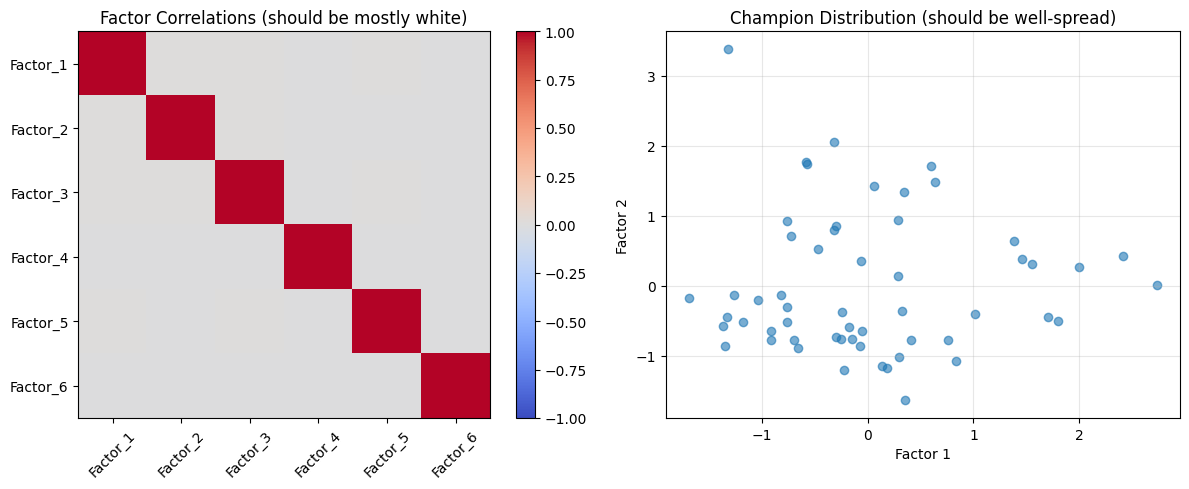

In [86]:
jungle_data = filtered_df
clustering_data, ready, loadings = prepare_and_evaluate_champions(jungle_data, n_factors=6)

In [73]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def explore_clusters(factor_scores, k_range=(3, 10)):
    """
    Explore optimal number of clusters using multiple methods.
    
    Args:
        factor_scores: DataFrame from feature engineering (champions x factors)
        k_range: Tuple of (min_k, max_k) to test (default 3-10)
    
    Returns:
        results: DataFrame with all metrics
        best_k: Recommended number of clusters
    """
    
    data = factor_scores.values
    min_k, max_k = k_range
    
    # Ensure we don't test more clusters than champions
    max_k = min(max_k, len(data) // 3)  # At least 3 champions per cluster
    k_values = range(min_k, max_k + 1)
    
    print(f"Testing k = {min_k} to {max_k}")
    print("="*50)
    
    # Step 1: Hierarchical clustering for visual inspection
    print("\n1. HIERARCHICAL CLUSTERING")
    print("-"*30)
    
    # Create linkage
    Z = linkage(data, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=factor_scores.index, leaf_rotation=90, leaf_font_size=8)
    plt.title('Champion Clustering Dendrogram (Ward Linkage)')
    plt.xlabel('Champions')
    plt.ylabel('Distance')
    
    # Add horizontal lines for different k values
    for k in [3, 4, 5, 6]:
        # Calculate cut height for k clusters
        cut_height = Z[-k+1, 2]
        plt.axhline(y=cut_height, c='gray', linestyle='--', alpha=0.5)
        plt.text(0, cut_height, f'k={k}', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Step 2: Test multiple algorithms
    print("\n2. TESTING MULTIPLE ALGORITHMS")
    print("-"*30)
    
    results = []
    
    for k in k_values:
        print(f"\nTesting k={k}:")
        
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(data)
        kmeans_silhouette = silhouette_score(data, kmeans_labels)
        kmeans_ch = calinski_harabasz_score(data, kmeans_labels)
        
        # Gaussian Mixture Model
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
        gmm.fit(data)
        gmm_labels = gmm.predict(data)
        gmm_silhouette = silhouette_score(data, gmm_labels)
        gmm_ch = calinski_harabasz_score(data, gmm_labels)
        gmm_bic = gmm.bic(data)
        gmm_aic = gmm.aic(data)
        
        # Store results
        results.append({
            'k': k,
            'kmeans_silhouette': kmeans_silhouette,
            'kmeans_ch': kmeans_ch,
            'gmm_silhouette': gmm_silhouette,
            'gmm_ch': gmm_ch,
            'gmm_bic': gmm_bic,
            'gmm_aic': gmm_aic
        })
        
        print(f"  K-Means: Silhouette={kmeans_silhouette:.3f}, CH={kmeans_ch:.1f}")
        print(f"  GMM: Silhouette={gmm_silhouette:.3f}, CH={gmm_ch:.1f}, BIC={gmm_bic:.1f}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Step 3: Find best k
    print("\n3. FINDING OPTIMAL K")
    print("-"*30)
    
    # Score each k (higher is better)
    results_df['score'] = (
        results_df['kmeans_silhouette'] * 0.25 +
        results_df['gmm_silhouette'] * 0.25 +
        (results_df['kmeans_ch'] / results_df['kmeans_ch'].max()) * 0.25 +
        (results_df['gmm_ch'] / results_df['gmm_ch'].max()) * 0.25
    )
    
    # Best k is highest score
    best_k = results_df.loc[results_df['score'].idxmax(), 'k']
    
    print(f"\nBest k = {best_k} (highest combined score)")
    
    # Step 4: Visualize metrics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Silhouette scores
    axes[0, 0].plot(results_df['k'], results_df['kmeans_silhouette'], 'o-', label='K-Means')
    axes[0, 0].plot(results_df['k'], results_df['gmm_silhouette'], 's-', label='GMM')
    axes[0, 0].set_title('Silhouette Score (Higher is Better)')
    axes[0, 0].set_xlabel('Number of Clusters (k)')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # CH Index
    axes[0, 1].plot(results_df['k'], results_df['kmeans_ch'], 'o-', label='K-Means')
    axes[0, 1].plot(results_df['k'], results_df['gmm_ch'], 's-', label='GMM')
    axes[0, 1].set_title('Calinski-Harabasz Index (Higher is Better)')
    axes[0, 1].set_xlabel('Number of Clusters (k)')
    axes[0, 1].set_ylabel('CH Index')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # BIC/AIC for GMM
    axes[1, 0].plot(results_df['k'], results_df['gmm_bic'], 'o-', label='BIC')
    axes[1, 0].plot(results_df['k'], results_df['gmm_aic'], 's-', label='AIC')
    axes[1, 0].set_title('GMM Information Criteria (Lower is Better)')
    axes[1, 0].set_xlabel('Number of Clusters (k)')
    axes[1, 0].set_ylabel('Information Criteria')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Combined score
    axes[1, 1].bar(results_df['k'], results_df['score'])
    axes[1, 1].set_title('Combined Score (Our Recommendation)')
    axes[1, 1].set_xlabel('Number of Clusters (k)')
    axes[1, 1].set_ylabel('Combined Score')
    axes[1, 1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].text(best_k, results_df['score'].max() * 0.9, f'Best k={best_k}', ha='center')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df, int(best_k)


def quick_cluster_preview(factor_scores, k):
    """
    Quick preview of what clusters would look like with chosen k.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k: Number of clusters to preview
    
    Returns:
        cluster_assignments: Series with champion cluster assignments
    """
    
    # Use GMM for preview (soft clustering advantages)
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    cluster_labels = gmm.fit_predict(factor_scores.values)
    
    # Create assignment series
    cluster_assignments = pd.Series(
        cluster_labels,
        index=factor_scores.index,
        name='cluster'
    )
    
    # Show preview
    print(f"\nCluster Preview (k={k}):")
    print("="*30)
    
    for cluster in range(k):
        members = cluster_assignments[cluster_assignments == cluster].index.tolist()
        print(f"\nCluster {cluster + 1}: {len(members)} champions")
        print(f"  {', '.join(members[:8])}")
        if len(members) > 8:
            print(f"  ... and {len(members) - 8} more")
    
    # Check for balance
    sizes = cluster_assignments.value_counts().sort_index()
    imbalance = sizes.max() / sizes.min()
    print(f"\nCluster balance: {imbalance:.1f}x (lower is better)")
    
    if imbalance > 3:
        print("⚠️  Warning: Clusters are imbalanced, consider different k")
    
    return cluster_assignments


# Main exploration function
def explore_optimal_clusters(factor_scores, k_range=(3, 8)):
    """
    Complete cluster exploration with recommendations.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k_range: Range of k values to test
    
    Returns:
        best_k: Recommended number of clusters
        metrics: DataFrame of all metrics for manual review
    """
    
    print("\nCLUSTER EXPLORATION")
    print("="*50)
    
    # Run exploration
    metrics, best_k = explore_clusters(factor_scores, k_range)
    
    # Show preview of best k
    print(f"\n\nRECOMMENDATION: Use k={best_k} clusters")
    cluster_preview = quick_cluster_preview(factor_scores, best_k)
    
    # Also show alternative k values
    alt_k = metrics.nlargest(3, 'score')['k'].tolist()
    alt_k = [k for k in alt_k if k != best_k][:2]
    
    if alt_k:
        print(f"\nAlternatives to consider: k={alt_k}")
        print("(Use quick_cluster_preview to examine these)")
    
    return best_k, metrics

Starting with 271 features
Removed 59 redundant features, keeping 212

Created 6 factors explaining 50.5% of variance

Top 3 features per factor:

Factor_1:
  avg_kills: 0.96
  avg_bounty_gold: 0.93
  avg_gold_earned_per_game: 0.92

Factor_2:
  avg_magic_damage_dealt_to_champions: 0.92
  pct_of_matches_with_spell_damage: 0.88
  avg_physical_damage_dealt_to_champions: 0.78

Factor_3:
  avg_individual_tower_takedowns: 0.76
  avg_indiv_dmg_dealt_to_buildings: 0.74
  avg_individual_inhibitor_takedowns: 0.70

Factor_4:
  pct_of_games_had_drag_takedown_min_5_to_7: 0.72
  avg_dragon_kills_by_team: 0.69
  pct_of_games_had_drag_takedown_min_11_to_15: 0.68

Factor_5:
  pct_of_matches_with_jungle: 0.49
  avg_items_completed: 0.48
  avg_dmg_shielded_on_team: 0.46

Factor_6:
  avg_effective_heal_and_shield: 0.55
  avg_dmg_shielded_on_team: 0.52
  avg_times_got_kill_after_hidden_with_ally: 0.50

FEATURE ENGINEERING EVALUATION

Quality Checks:
  enough_features: ✓ PASS
  good_variance: ✓ PASS
  indep

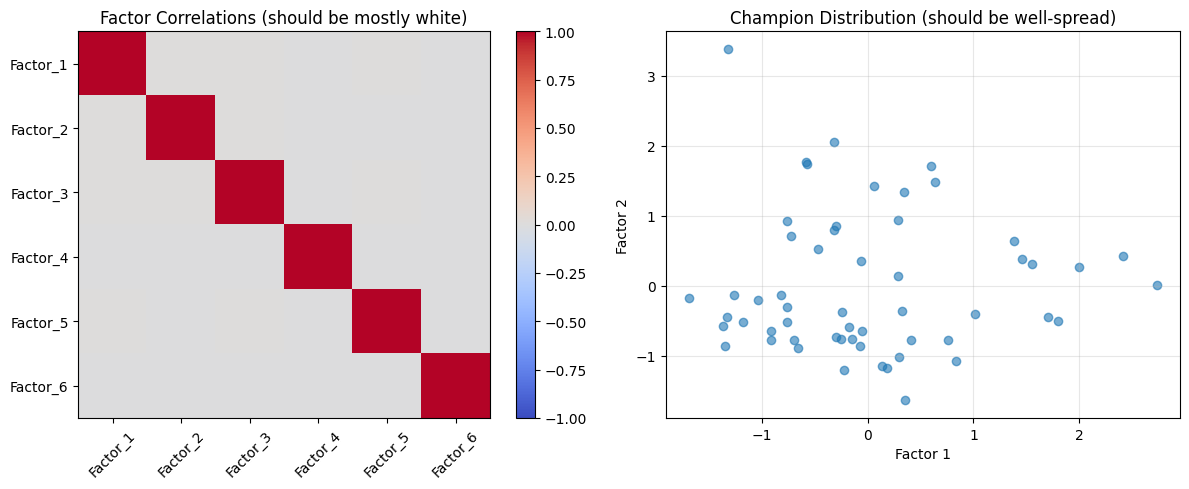


CLUSTER EXPLORATION
Testing k = 3 to 8

1. HIERARCHICAL CLUSTERING
------------------------------


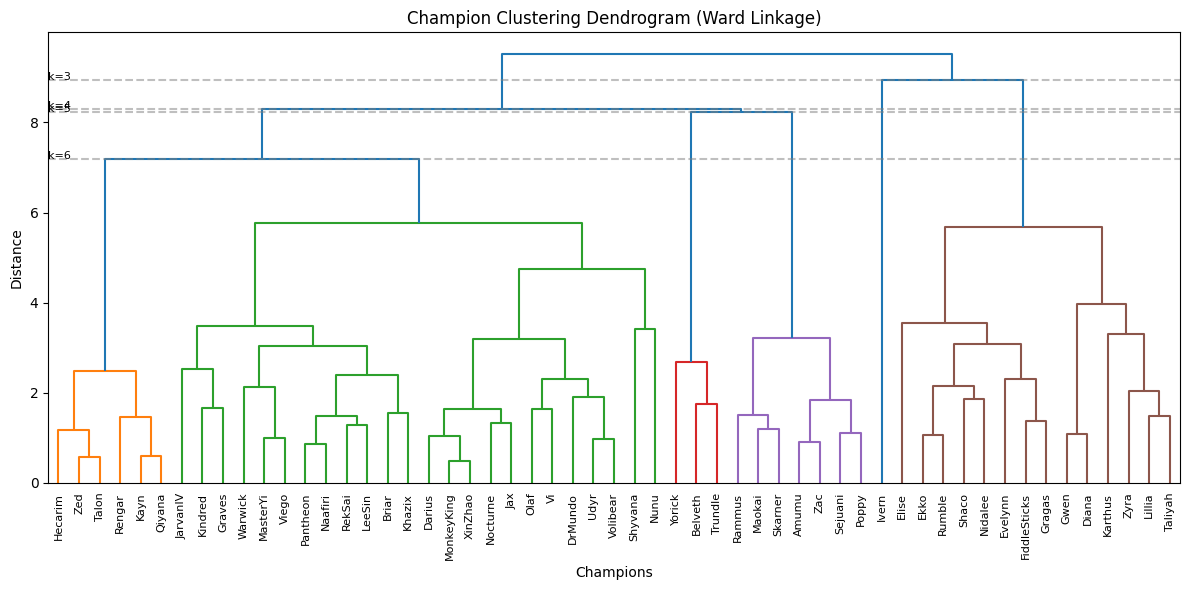


2. TESTING MULTIPLE ALGORITHMS
------------------------------

Testing k=3:
  K-Means: Silhouette=0.176, CH=9.0
  GMM: Silhouette=0.193, CH=8.6, BIC=954.2

Testing k=4:
  K-Means: Silhouette=0.210, CH=9.9
  GMM: Silhouette=0.210, CH=9.9, BIC=947.6

Testing k=5:
  K-Means: Silhouette=0.179, CH=10.2
  GMM: Silhouette=0.137, CH=7.9, BIC=918.6

Testing k=6:
  K-Means: Silhouette=0.202, CH=11.8
  GMM: Silhouette=0.187, CH=10.7, BIC=971.5

Testing k=7:
  K-Means: Silhouette=0.235, CH=13.5
  GMM: Silhouette=0.162, CH=8.8, BIC=855.9

Testing k=8:
  K-Means: Silhouette=0.236, CH=13.6
  GMM: Silhouette=0.203, CH=10.4, BIC=822.3

3. FINDING OPTIMAL K
------------------------------

Best k = 8 (highest combined score)


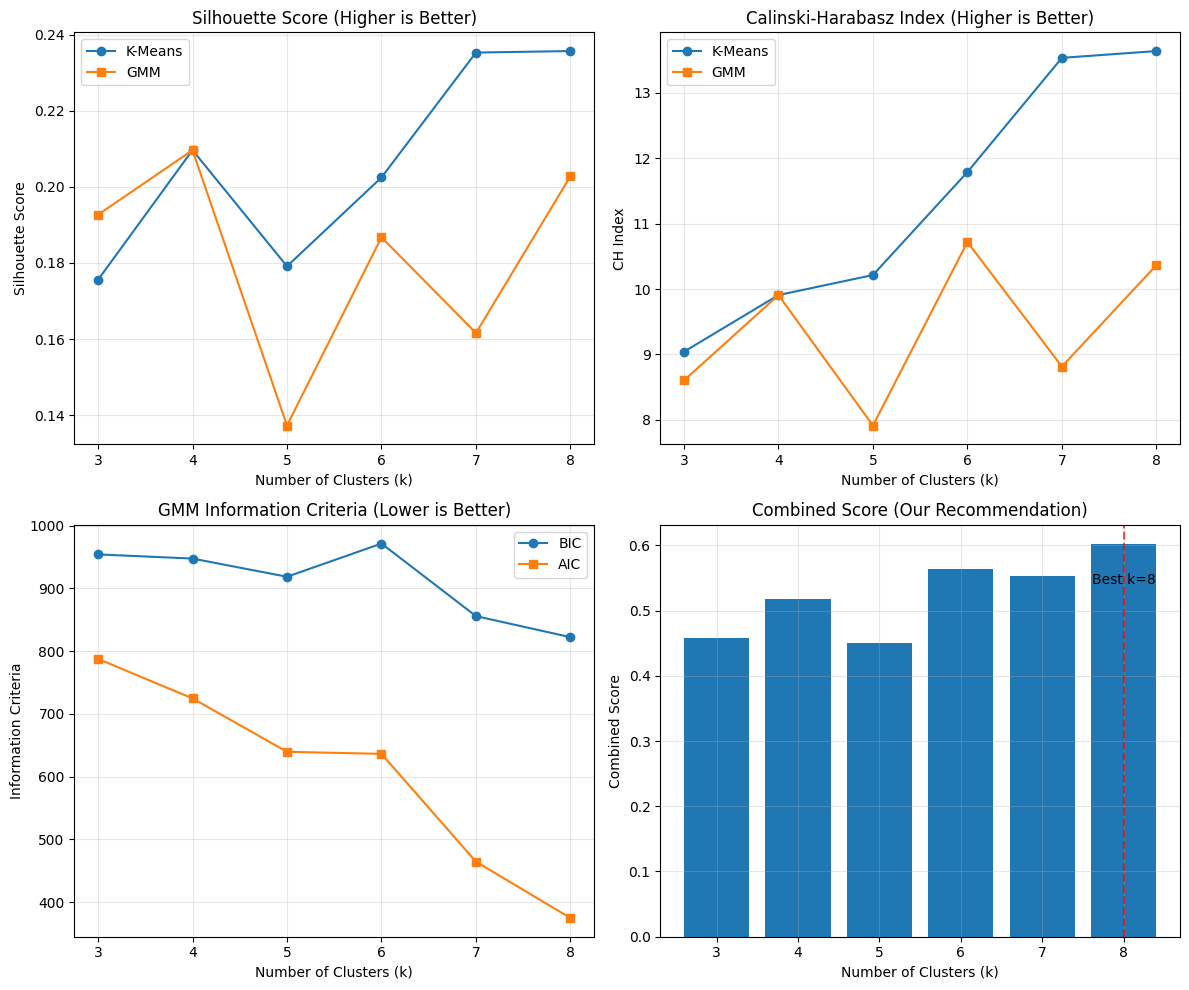



RECOMMENDATION: Use k=8 clusters

Cluster Preview (k=8):

Cluster 1: 3 champions
  Yorick, Belveth, Trundle

Cluster 2: 7 champions
  Udyr, Olaf, Shyvana, DrMundo, Volibear, Gwen, Diana

Cluster 3: 17 champions
  Kayn, MonkeyKing, Pantheon, Briar, Rengar, Nocturne, Zed, Darius
  ... and 9 more

Cluster 4: 4 champions
  Lillia, Taliyah, Zyra, Karthus

Cluster 5: 3 champions
  Ivern, JarvanIV, Nunu

Cluster 6: 4 champions
  Rumble, FiddleSticks, Gragas, Evelynn

Cluster 7: 10 champions
  Warwick, RekSai, MasterYi, Shaco, Kindred, Ekko, Nidalee, Viego
  ... and 2 more

Cluster 8: 7 champions
  Sejuani, Maokai, Amumu, Zac, Skarner, Poppy, Rammus

Cluster balance: 5.7x (lower is better)
⚠️  Warning: Clusters are imbalanced, consider different k

Alternatives to consider: k=[6, 7]
(Use quick_cluster_preview to examine these)

Cluster Preview (k=8):

Cluster 1: 3 champions
  Yorick, Belveth, Trundle

Cluster 2: 7 champions
  Udyr, Olaf, Shyvana, DrMundo, Volibear, Gwen, Diana

Cluster 3: 17

In [ ]:
clustering_data, ready = prepare_and_evaluate_champions(jungle_data, n_factors=6)

if ready:
    # Run cluster exploration
    best_k, metrics = explore_optimal_clusters(clustering_data, k_range=(3, 8))
    
    # Preview a specific k
    preview = quick_cluster_preview(clustering_data, k=best_k)

In [77]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def final_clustering(factor_scores, k, method='gmm'):
    """
    Perform final clustering with the chosen k.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k: Number of clusters (from exploration phase)
        method: 'gmm' or 'hierarchical' (default gmm)
    
    Returns:
        results: Dictionary containing:
            - assignments: Series of cluster assignments
            - probabilities: DataFrame of cluster probabilities (GMM only)
            - centers: DataFrame of cluster centers
            - model: Fitted model for future use
    """
    
    print(f"\nFINAL CLUSTERING (k={k})")
    print("="*50)
    
    data = factor_scores.values
    
    if method == 'gmm':
        # Fit GMM
        model = GaussianMixture(n_components=k, 
                               covariance_type='full',
                               random_state=42, 
                               n_init=20,  # Extra runs for stability
                               max_iter=200)
        model.fit(data)
        
        # Get hard assignments
        labels = model.predict(data)
        
        # Get soft assignments (probabilities)
        probs = model.predict_proba(data)
        
        # Create probability DataFrame
        prob_df = pd.DataFrame(
            probs,
            index=factor_scores.index,
            columns=[f'Cluster_{i+1}_prob' for i in range(k)]
        )
        
        # Identify mixed-identity champions
        max_prob = prob_df.max(axis=1)
        mixed_champions = factor_scores.index[max_prob < 0.8].tolist()
        
        if mixed_champions:
            print(f"\nMixed-identity champions (prob < 0.8): {len(mixed_champions)}")
            for champ in mixed_champions[:5]:
                top_two = prob_df.loc[champ].nlargest(2)
                print(f"  {champ}: {top_two.index[0]}={top_two.values[0]:.2f}, "
                      f"{top_two.index[1]}={top_two.values[1]:.2f}")
            if len(mixed_champions) > 5:
                print(f"  ... and {len(mixed_champions)-5} more")
    
    else:  # hierarchical
        from sklearn.cluster import AgglomerativeClustering
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = model.fit_predict(data)
        prob_df = None
    
    # Create assignments
    assignments = pd.Series(
        labels,
        index=factor_scores.index,
        name='cluster'
    )
    
    # Calculate cluster centers - FIXED
    centers_array = np.zeros((k, data.shape[1]))
    for i in range(k):
        mask = labels == i
        centers_array[i] = data[mask].mean(axis=0)
    
    centers = pd.DataFrame(
        centers_array,
        index=[f'Cluster_{i+1}' for i in range(k)],
        columns=factor_scores.columns,
        dtype=float  # Ensure numeric dtype
    )
    
    # Show results
    print(f"\nCluster Sizes:")
    for i in range(k):
        size = (labels == i).sum()
        pct = size / len(labels) * 100
        print(f"  Cluster {i+1}: {size} champions ({pct:.1f}%)")
    
    # Create results dictionary
    results = {
        'assignments': assignments,
        'probabilities': prob_df,
        'centers': centers,
        'model': model
    }
    
    return results


def analyze_clusters(factor_scores, clustering_results, original_features=None):
    """
    Analyze and visualize the final clusters.
    
    Args:
        factor_scores: DataFrame from feature engineering
        clustering_results: Results from final_clustering
        original_features: Optional DataFrame of original features for interpretation
    
    Returns:
        cluster_profiles: DataFrame describing each cluster
    """
    
    assignments = clustering_results['assignments']
    centers = clustering_results['centers']
    k = len(centers)
    
    print("\nCLUSTER ANALYSIS")
    print("="*50)
    
    # 1. Cluster Profiles based on factors
    print("\n1. CLUSTER PROFILES (Factor Space)")
    print("-"*40)
    
    cluster_profiles = centers.copy()  # Use the centers as profiles
    
    for i in range(k):
        members = assignments[assignments == i].index.tolist()
        
        print(f"\nCluster {i+1} ({len(members)} champions):")
        print(f"Members: {', '.join(members[:10])}")
        if len(members) > 10:
            print(f"         ... and {len(members)-10} more")
        
        # Identify defining factors (highest absolute values)
        center_values = centers.iloc[i]
        defining_factors = center_values.abs().nlargest(3)
        
        print("Defining characteristics:")
        for factor, value in defining_factors.items():
            direction = "High" if center_values[factor] > 0 else "Low"
            print(f"  - {direction} {factor}: {value:.2f}")
    
    # 2. Visualizations
    # 2a. Cluster centers heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cluster_profiles, 
                cmap='coolwarm', 
                center=0,
                annot=True, 
                fmt='.2f',
                cbar_kws={'label': 'Factor Value'})
    plt.title('Cluster Profiles (Factor Values)')
    plt.xlabel('Factors')
    plt.ylabel('Clusters')
    plt.tight_layout()
    plt.show()
    
    # 2b. Champions in 2D space
    if factor_scores.shape[1] >= 2:
        plt.figure(figsize=(10, 8))
        
        # Plot champions colored by cluster
        for i in range(k):
            mask = assignments == i
            cluster_data = factor_scores[mask]
            plt.scatter(cluster_data.iloc[:, 0], 
                       cluster_data.iloc[:, 1],
                       label=f'Cluster {i+1}',
                       alpha=0.7,
                       s=100)
        
        # Add cluster centers
        plt.scatter(centers.iloc[:, 0], 
                   centers.iloc[:, 1],
                   c='black',
                   marker='X',
                   s=200,
                   edgecolors='white',
                   linewidth=2,
                   label='Centers')
        
        plt.xlabel('Factor 1')
        plt.ylabel('Factor 2')
        plt.title('Champions by Cluster (First 2 Factors)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 3. Cluster separation quality
    print("\n2. CLUSTER SEPARATION QUALITY")
    print("-"*40)
    
    # Calculate average distance between cluster centers
    center_distances = []
    for i in range(k):
        for j in range(i+1, k):
            dist = np.linalg.norm(centers.iloc[i].values - centers.iloc[j].values)
            center_distances.append(dist)
    
    avg_separation = np.mean(center_distances)
    min_separation = np.min(center_distances)
    
    print(f"Average cluster separation: {avg_separation:.2f}")
    print(f"Minimum cluster separation: {min_separation:.2f}")
    
    if min_separation < 1.0:
        print("⚠️  Warning: Some clusters are very close together")
    else:
        print("✓ Clusters are well separated")
    
    return cluster_profiles


def save_clustering_results(clustering_results, factor_scores, output_prefix='champion_clusters'):
    """
    Save all clustering results for future use.
    
    Args:
        clustering_results: Results from final_clustering
        factor_scores: DataFrame from feature engineering
        output_prefix: Prefix for output files
    """
    
    # Save assignments
    clustering_results['assignments'].to_csv(f'{output_prefix}_assignments.csv', header=True)
    
    # Save probabilities if GMM
    if clustering_results['probabilities'] is not None:
        clustering_results['probabilities'].to_csv(f'{output_prefix}_probabilities.csv')
    
    # Save cluster centers
    clustering_results['centers'].to_csv(f'{output_prefix}_centers.csv')
    
    # Save model
    import joblib
    joblib.dump(clustering_results['model'], f'{output_prefix}_model.pkl')
    
    print(f"\nResults saved with prefix: {output_prefix}")
    print(f"  - {output_prefix}_assignments.csv")
    if clustering_results['probabilities'] is not None:
        print(f"  - {output_prefix}_probabilities.csv")
    print(f"  - {output_prefix}_centers.csv")
    print(f"  - {output_prefix}_model.pkl")


# All-in-one clustering function
def perform_final_clustering(factor_scores, k, save_results=True, output_prefix='champion_clusters'):
    """
    Complete final clustering with analysis.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k: Number of clusters (from exploration)
        save_results: Whether to save results to files
        output_prefix: Prefix for saved files
    
    Returns:
        assignments: Series with final cluster assignments
        cluster_profiles: DataFrame with cluster characteristics
    """
    
    # Perform clustering
    results = final_clustering(factor_scores, k, method='gmm')
    
    # Analyze clusters
    profiles = analyze_clusters(factor_scores, results)
    
    # Save if requested
    if save_results:
        save_clustering_results(results, factor_scores, output_prefix)
    
    # Return key outputs
    return results['assignments'], profiles


CLUSTER EXPLORATION
Testing k = 3 to 8

1. HIERARCHICAL CLUSTERING
------------------------------


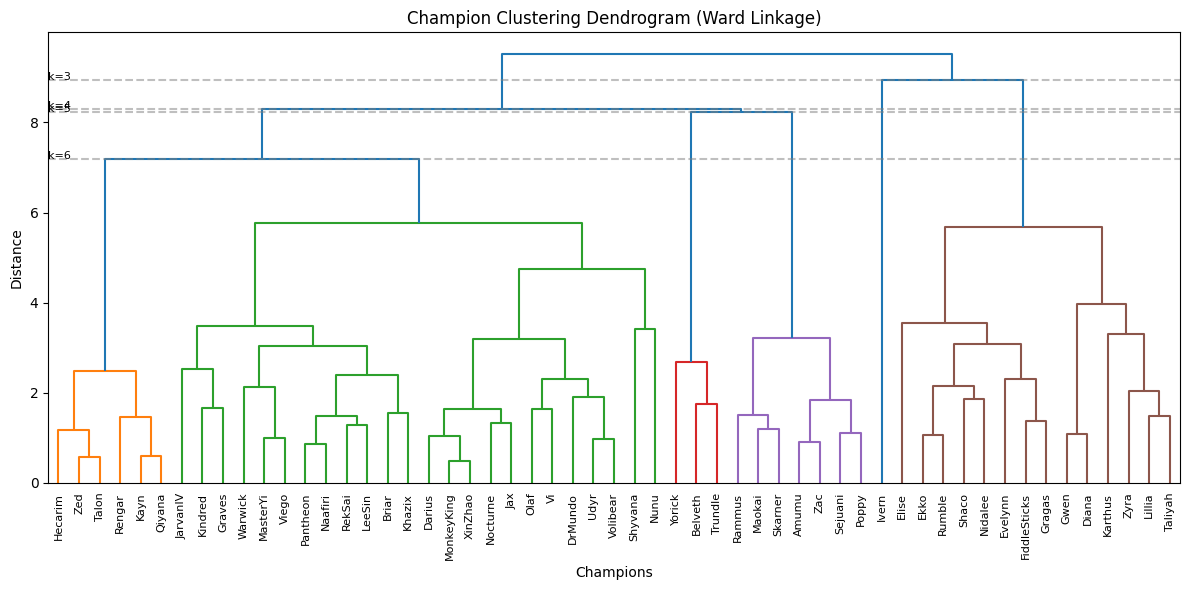


2. TESTING MULTIPLE ALGORITHMS
------------------------------

Testing k=3:
  K-Means: Silhouette=0.176, CH=9.0
  GMM: Silhouette=0.193, CH=8.6, BIC=954.2

Testing k=4:
  K-Means: Silhouette=0.210, CH=9.9
  GMM: Silhouette=0.210, CH=9.9, BIC=947.6

Testing k=5:
  K-Means: Silhouette=0.179, CH=10.2
  GMM: Silhouette=0.137, CH=7.9, BIC=918.6

Testing k=6:
  K-Means: Silhouette=0.202, CH=11.8
  GMM: Silhouette=0.187, CH=10.7, BIC=971.5

Testing k=7:
  K-Means: Silhouette=0.235, CH=13.5
  GMM: Silhouette=0.162, CH=8.8, BIC=855.9

Testing k=8:
  K-Means: Silhouette=0.236, CH=13.6
  GMM: Silhouette=0.203, CH=10.4, BIC=822.3

3. FINDING OPTIMAL K
------------------------------

Best k = 8 (highest combined score)


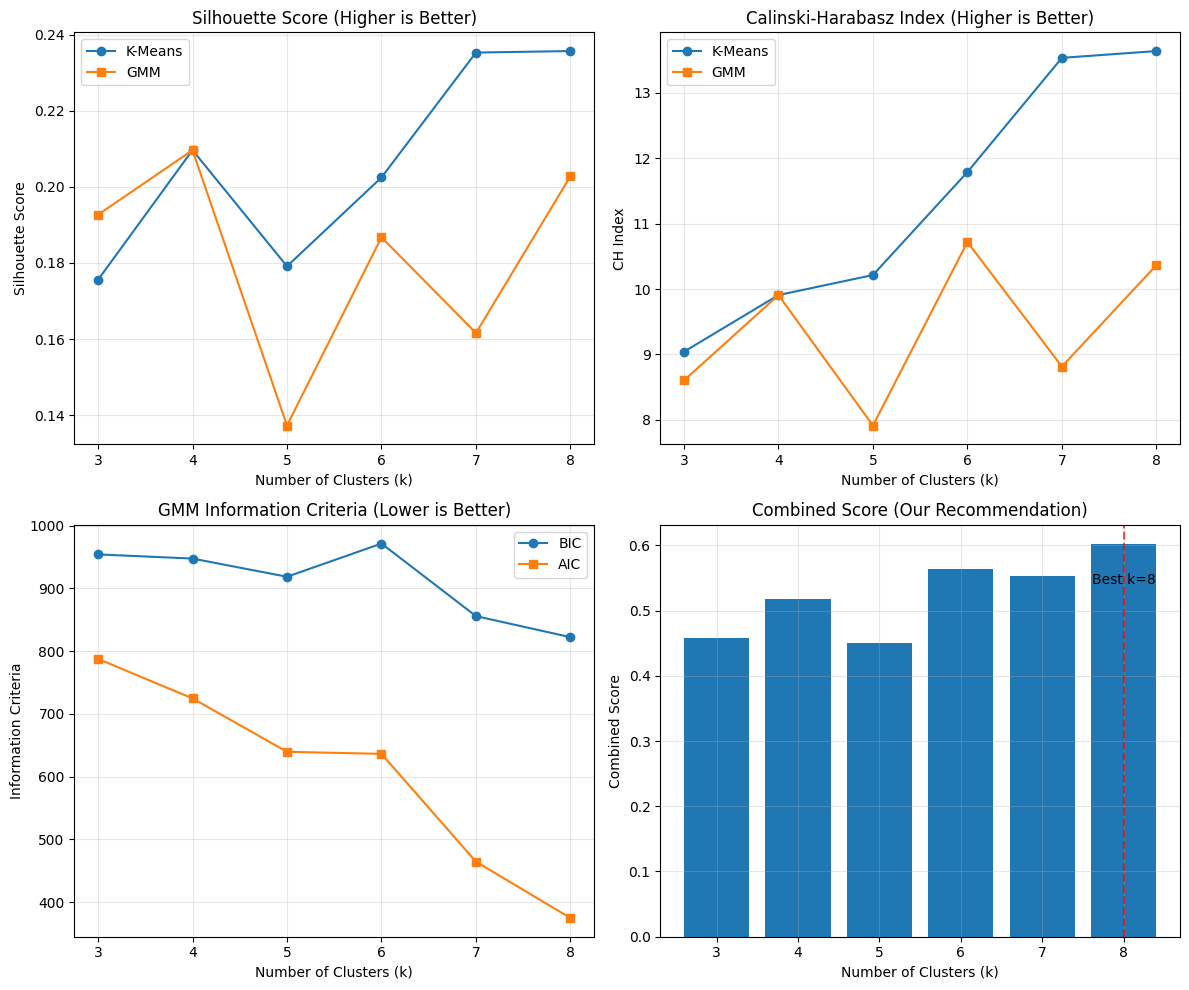



RECOMMENDATION: Use k=8 clusters

Cluster Preview (k=8):

Cluster 1: 3 champions
  Yorick, Belveth, Trundle

Cluster 2: 7 champions
  Udyr, Olaf, Shyvana, DrMundo, Volibear, Gwen, Diana

Cluster 3: 17 champions
  Kayn, MonkeyKing, Pantheon, Briar, Rengar, Nocturne, Zed, Darius
  ... and 9 more

Cluster 4: 4 champions
  Lillia, Taliyah, Zyra, Karthus

Cluster 5: 3 champions
  Ivern, JarvanIV, Nunu

Cluster 6: 4 champions
  Rumble, FiddleSticks, Gragas, Evelynn

Cluster 7: 10 champions
  Warwick, RekSai, MasterYi, Shaco, Kindred, Ekko, Nidalee, Viego
  ... and 2 more

Cluster 8: 7 champions
  Sejuani, Maokai, Amumu, Zac, Skarner, Poppy, Rammus

Cluster balance: 5.7x (lower is better)
⚠️  Warning: Clusters are imbalanced, consider different k

Alternatives to consider: k=[6, 7]
(Use quick_cluster_preview to examine these)

FINAL CLUSTERING (k=8)

Mixed-identity champions (prob < 0.8): 1
  Graves: Cluster_3_prob=0.78, Cluster_7_prob=0.22

Cluster Sizes:
  Cluster 1: 3 champions (5.5%)
  

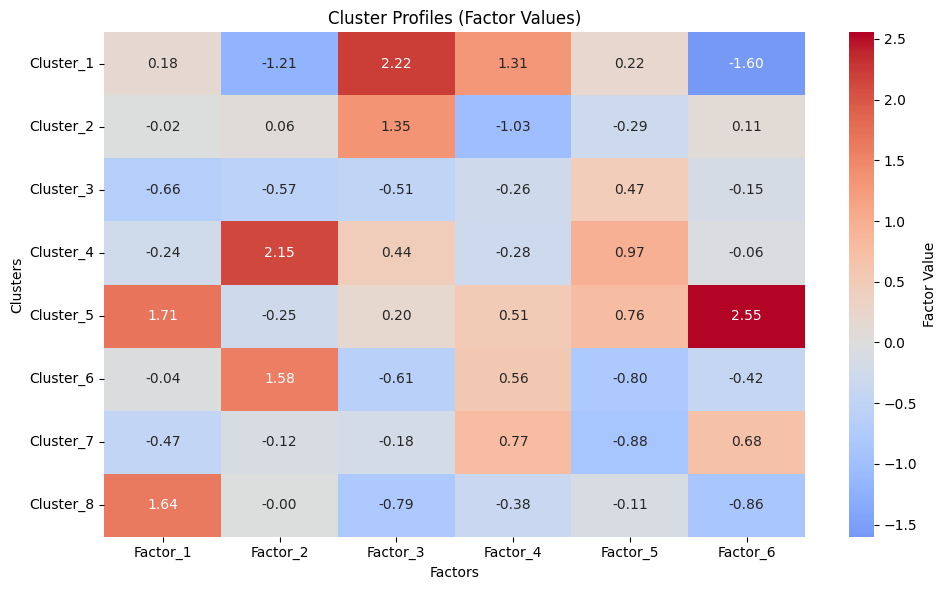

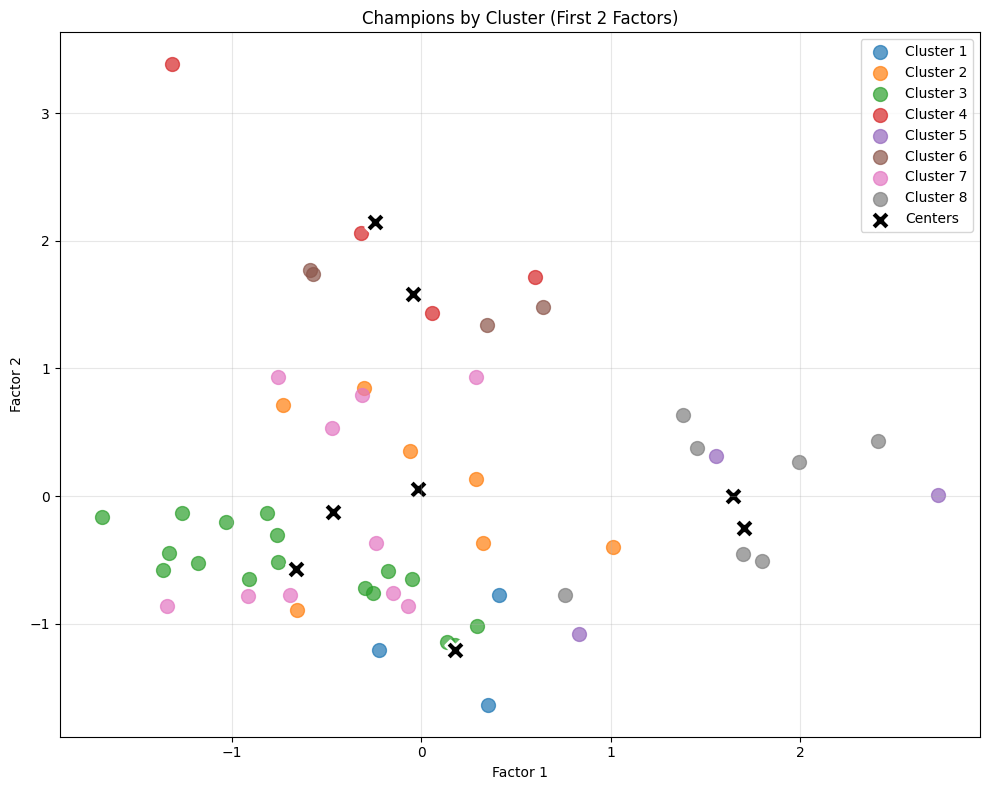


2. CLUSTER SEPARATION QUALITY
----------------------------------------
Average cluster separation: 3.29
Minimum cluster separation: 1.98
✓ Clusters are well separated

Results saved with prefix: jungle_champions
  - jungle_champions_assignments.csv
  - jungle_champions_probabilities.csv
  - jungle_champions_centers.csv
  - jungle_champions_model.pkl


In [79]:
# Continuing from exploration phase:
best_k, metrics = explore_optimal_clusters(clustering_data)

# Perform final clustering
assignments, cluster_profiles = perform_final_clustering(
    clustering_data,
    k=best_k,
    save_results=True,
    output_prefix='jungle_champions'
)

# Access results:
#print(f"Champion X is in cluster: {assignments['Champion_X']}")

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def interpret_clusters(factor_loadings, cluster_assignments, original_data):
    """
    Show what original features define each cluster.
    
    Args:
        factor_loadings: Loadings from feature engineering
        cluster_assignments: Series from final clustering
        original_data: Original champion data
        
    Returns:
        cluster_features: DataFrame showing top features per cluster
        problematic_features: List of features to potentially remove
    """
    
    print("\nCLUSTER INTERPRETATION")
    print("="*50)
    
    # Get only the features that were used
    used_features = factor_loadings.index.tolist()
    data_subset = original_data[used_features].astype(float)  # Ensure numeric
    
    # Calculate average values per cluster
    n_clusters = cluster_assignments.nunique()
    cluster_means = pd.DataFrame()
    
    for i in range(n_clusters):
        mask = cluster_assignments == i
        cluster_means[f'Cluster_{i+1}'] = data_subset[mask].mean()
    
    # Calculate % difference from overall average
    overall_mean = data_subset.mean()
    
    # Create percentage difference matrix
    pct_diff = pd.DataFrame(index=data_subset.columns)
    for col in cluster_means.columns:
        # Safe division - avoid zeros
        safe_mean = overall_mean.copy()
        safe_mean[safe_mean == 0] = 1e-10
        pct_diff[col] = ((cluster_means[col] - overall_mean) / safe_mean * 100)
    
    # Show top 5 features for each cluster
    print("\nTOP FEATURES PER CLUSTER (% above average):")
    print("-"*40)
    
    cluster_features = {}
    for i in range(n_clusters):
        cluster_name = f'Cluster_{i+1}'
        size = (cluster_assignments == i).sum()
        
        # Get features that differ most from average
        cluster_diffs = pct_diff[cluster_name].astype(float)
        abs_diffs = cluster_diffs.abs()
        top_indices = abs_diffs.nlargest(10).index
        
        print(f"\n{cluster_name} ({size} champions):")
        for feat in top_indices[:5]:
            value = cluster_diffs[feat]
            # Skip features where the base value is essentially zero
            if abs(overall_mean[feat]) > 1e-9:
                print(f"  {feat}: {value:+.1f}%")
        
        cluster_features[cluster_name] = top_indices.tolist()[:5]
    
    # Find problematic features (high variance within clusters)
    print("\n\nFEATURE QUALITY CHECK:")
    print("-"*40)
    
    problematic_features = []
    
    for feature in used_features:
        # Calculate coefficient of variation within each cluster
        within_cluster_cvs = []
        for i in range(n_clusters):
            mask = cluster_assignments == i
            cluster_values = data_subset[mask][feature]
            if len(cluster_values) > 1 and cluster_values.mean() != 0:
                cv = cluster_values.std() / abs(cluster_values.mean())
                within_cluster_cvs.append(cv)
        
        if within_cluster_cvs:  # Only if we have valid CVs
            avg_cv = np.mean(within_cluster_cvs)
            if avg_cv > 0.5:  # High variance within clusters
                problematic_features.append(feature)
    
    if problematic_features:
        print(f"Features with high within-cluster variance ({len(problematic_features)}):")
        for feat in problematic_features[:10]:  # Limit display
            print(f"  - {feat}")
        if len(problematic_features) > 10:
            print(f"  ... and {len(problematic_features) - 10} more")
    else:
        print("✓ All features show good consistency")
    
    # Simple heatmap of top features
    top_features = list(set([f for feats in cluster_features.values() for f in feats]))[:15]
    # Filter out features with near-zero means
    top_features = [f for f in top_features if abs(overall_mean[f]) > 1e-9]
    
    if top_features:
        plt.figure(figsize=(10, 6))
        heatmap_data = pct_diff.loc[top_features].astype(float)
        sns.heatmap(heatmap_data.T,
                    cmap='RdBu_r', center=0, annot=True, fmt='.0f')
        plt.title('Key Features by Cluster (% difference from average)')
        plt.tight_layout()
        plt.show()
    
    return cluster_features, problematic_features


def validate_clustering(cluster_assignments):
    """
    Check if clustering meets basic quality criteria.
    
    Args:
        cluster_assignments: Series from clustering
        
    Returns:
        is_valid: Boolean
        issues: List of issues found
    """
    
    print("\nVALIDATION:")
    print("-"*40)
    
    issues = []
    
    # Check cluster sizes
    sizes = cluster_assignments.value_counts()
    
    if sizes.min() < 3:
        issues.append(f"Cluster too small ({sizes.min()} champions)")
    
    if sizes.max() / sizes.min() > 5:
        issues.append(f"Imbalanced clusters (largest is {sizes.max()/sizes.min():.1f}x bigger)")
    
    if issues:
        print("Issues found:")
        for issue in issues:
            print(f"  ⚠️  {issue}")
    else:
        print("✓ Clustering passed validation")
    
    return len(issues) == 0, issues


def interpret_and_validate(factor_loadings, cluster_assignments, original_data):
    """
    Complete interpretation and validation.
    
    Args:
        factor_loadings: From feature engineering
        cluster_assignments: From clustering
        original_data: Original champion data
        
    Returns:
        is_good: Boolean - whether clustering is ready to use
        features_to_remove: List of problematic features (if any)
    """
    
    # Interpret clusters
    cluster_features, problematic_features = interpret_clusters(
        factor_loadings, cluster_assignments, original_data
    )
    
    # Validate
    is_valid, issues = validate_clustering(cluster_assignments)
    
    # Decision
    print("\n" + "="*50)
    print("FINAL DECISION:")
    print("="*50)
    
    is_good = is_valid and len(problematic_features) == 0
    
    if is_good:
        print("\n✓ CLUSTERING IS READY TO USE")
    else:
        print("\n⚠️  REFINEMENT NEEDED")
        
        if problematic_features:
            print(f"\nRemove these {len(problematic_features)} features and rerun:")
            print(f"features_to_remove = {problematic_features[:20]}")  # Show first 20
            if len(problematic_features) > 20:
                print(f"# ... and {len(problematic_features) - 20} more")
            print("\nThen:")
            print("cleaned_data = original_data.drop(columns=features_to_remove)")
            print("# Restart from feature engineering with cleaned_data")
    
    return is_good, problematic_features


CLUSTER INTERPRETATION

TOP FEATURES PER CLUSTER (% above average):
----------------------------------------

Cluster_1 (3 champions):
  avg_individual_solo_baron_kills: +520.5%
  pct_of_games_individual_took_1st_tower_quick: +431.7%
  pct_of_matches_with_life_steal: +331.2%
  pct_of_matches_with_attack_speed: +266.9%
  pct_of_matches_with_teleport: +251.3%

Cluster_2 (7 champions):
  pct_of_matches_with_barrier: +340.2%
  pct_of_matches_with_ghost: +309.1%
  pct_of_matches_with_spell_vamp: +258.8%
  avg_times_outnumbered_nexus_kill: +209.3%
  avg_times_took_large_damage_survived: +136.0%

Cluster_3 (17 champions):
  pct_of_matches_with_armor_penetration: +154.0%
  avg_takedowns_in_enemy_fountain: +131.9%
  total_games_completed_supp_quest_first: -100.0%
  pct_of_matches_with_barrier: -100.0%
  percent_of_games_with_fully_stacked_mejais: -100.0%

Cluster_4 (4 champions):
  pct_of_matches_with_exhaust: +1083.6%
  pct_of_matches_with_mana: +518.8%
  pct_of_matches_with_magic_penetration

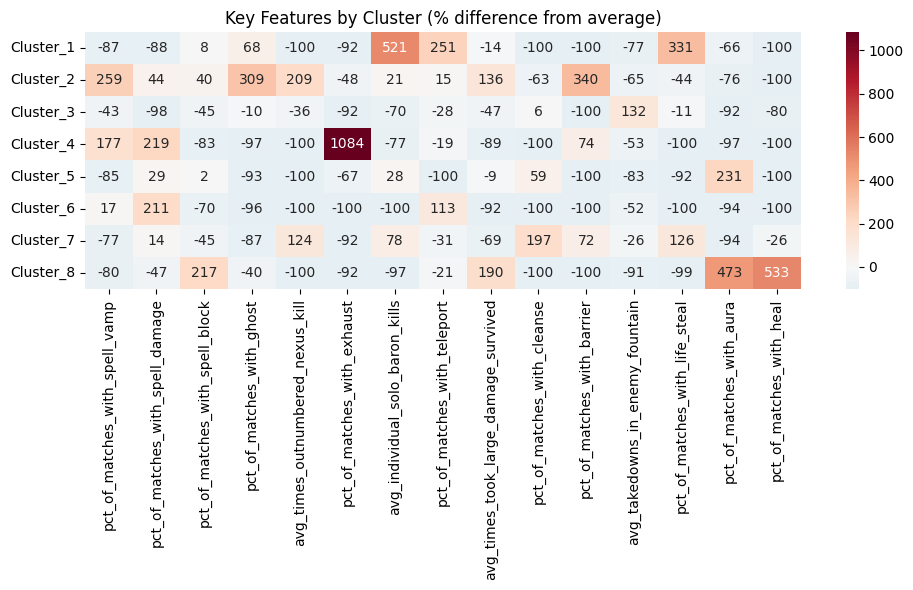


VALIDATION:
----------------------------------------
Issues found:
  ⚠️  Imbalanced clusters (largest is 5.7x bigger)

FINAL DECISION:

⚠️  REFINEMENT NEEDED

Remove these 67 features and rerun:
features_to_remove = ['champion_id', 'total_games_played_in_role', 'pct_of_games_with_highest_damage_dealt', 'avg_magic_damage_dealt_to_champions', 'avg_physical_damage_dealt_to_champions', 'avg_true_damage_dealt_to_champions', 'avg_largest_critical_strike', 'avg_times_killed_champ_took_full_team_damage_and_survived', 'avg_times_took_large_damage_survived', 'pct_of_games_with_highest_crowd_control_score', 'avg_time_ccing_others', 'avg_enemy_champion_immobilizations', 'avg_heals_on_teammate', 'avg_dmg_shielded_on_team', 'avg_effective_heal_and_shield', 'total_games_completed_supp_quest_first', 'avg_spell2_casts', 'avg_spell3_casts', 'avg_spell4_casts', 'avg_skillshots_landed_early_game']
# ... and 47 more

Then:
cleaned_data = original_data.drop(columns=features_to_remove)
# Restart from featur

In [91]:
# After clustering is done:
is_good, features_to_remove = interpret_and_validate(
    loadings,           # saved from feature engineering step
    assignments,        # from perform_final_clustering
    filtered_df  # your original data
)

if not is_good and features_to_remove:
    # Remove problematic features and restart
    cleaned_data = filtered_df.drop(columns=features_to_remove)
    # Go back to step 1 with cleaned_data

Starting with 204 features
Removed 52 redundant features, keeping 152

Created 6 factors explaining 55.0% of variance

Top 3 features per factor:

Factor_1:
  avg_assists: 0.99
  avg_full_team_takedowns: 0.90
  avg_kills: 0.85

Factor_2:
  avg_first_takedown_time: 0.89
  avg_takedowns: 0.89
  avg_total_team_champ_kills: 0.77

Factor_3:
  pct_of_matches_with_jungle: 0.71
  avg_jg_cs_before_10m: 0.70
  avg_ally_jungle_minions_killed: 0.69

Factor_4:
  avg_individual_tower_takedowns: 0.70
  avg_individual_inhibitor_takedowns: 0.61
  pct_of_games_individual_had_1st_turret_assist: 0.57

Factor_5:
  pct_of_games_team_took_first_dragon: 0.83
  pct_of_games_had_drag_takedown: 0.74
  pct_of_games_with_perfect_drag_soul_taken: 0.69

Factor_6:
  avg_inhib_kills_by_team: 0.85
  avg_tower_kills_by_team: 0.82
  pct_of_games_team_took_first_inhib: 0.67

FEATURE ENGINEERING EVALUATION

Quality Checks:
  enough_features: ✓ PASS
  good_variance: ✓ PASS
  independent_factors: ✓ PASS
  good_coverage: ✓ PA

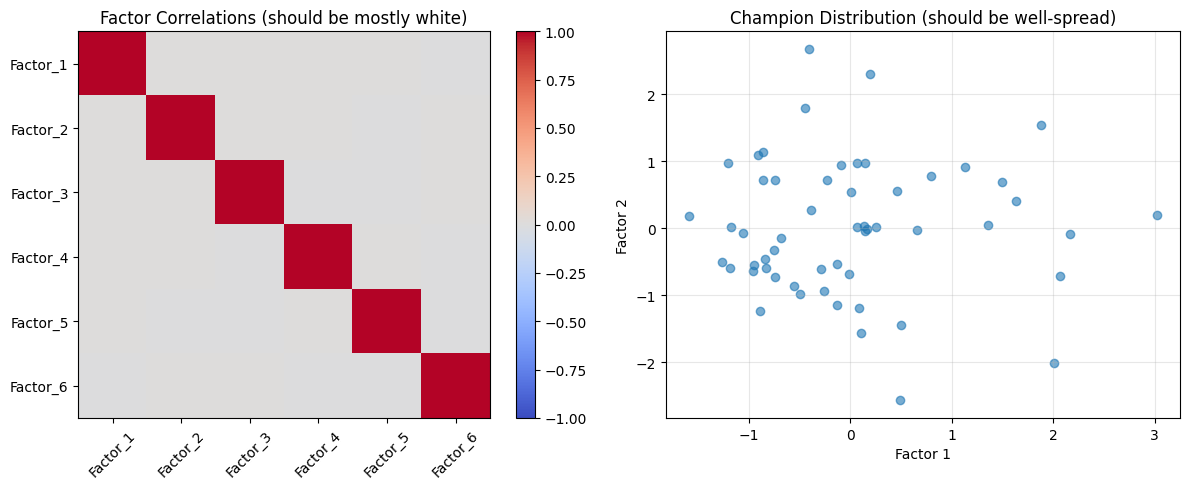


CLUSTER EXPLORATION
Testing k = 3 to 8

1. HIERARCHICAL CLUSTERING
------------------------------


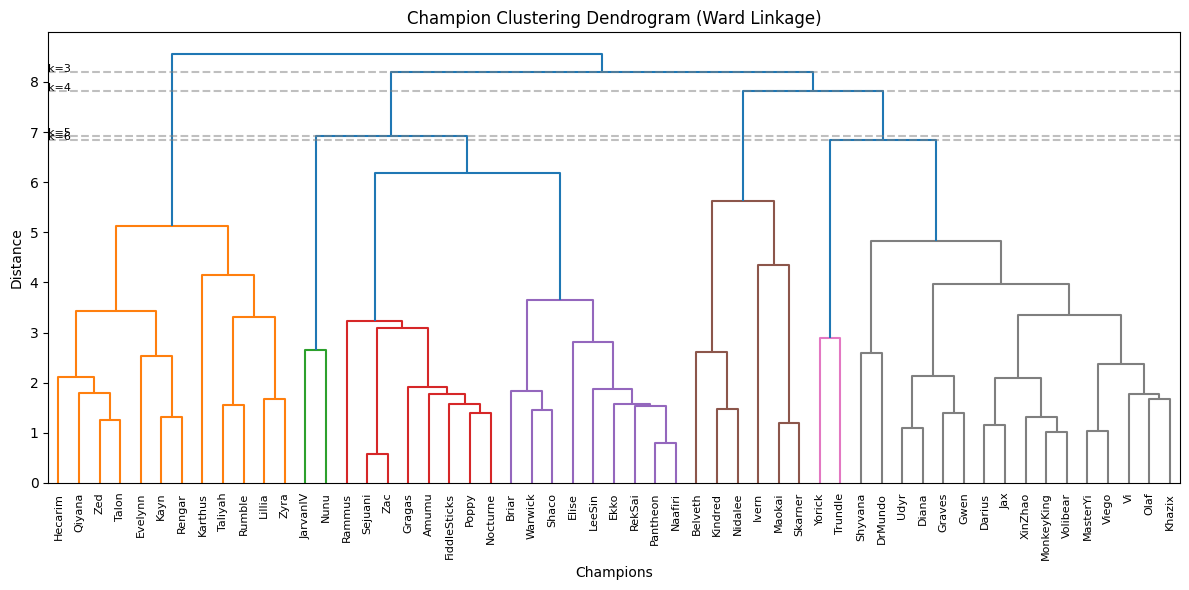


2. TESTING MULTIPLE ALGORITHMS
------------------------------

Testing k=3:
  K-Means: Silhouette=0.140, CH=8.0
  GMM: Silhouette=0.114, CH=6.5, BIC=1020.8

Testing k=4:
  K-Means: Silhouette=0.133, CH=7.8
  GMM: Silhouette=0.129, CH=6.4, BIC=1029.9

Testing k=5:
  K-Means: Silhouette=0.160, CH=8.1
  GMM: Silhouette=0.135, CH=7.2, BIC=966.7

Testing k=6:
  K-Means: Silhouette=0.153, CH=8.3
  GMM: Silhouette=0.096, CH=6.6, BIC=1047.9

Testing k=7:
  K-Means: Silhouette=0.182, CH=8.9
  GMM: Silhouette=0.149, CH=8.1, BIC=912.5

Testing k=8:
  K-Means: Silhouette=0.161, CH=9.0
  GMM: Silhouette=0.115, CH=7.2, BIC=1000.4

3. FINDING OPTIMAL K
------------------------------

Best k = 7 (highest combined score)


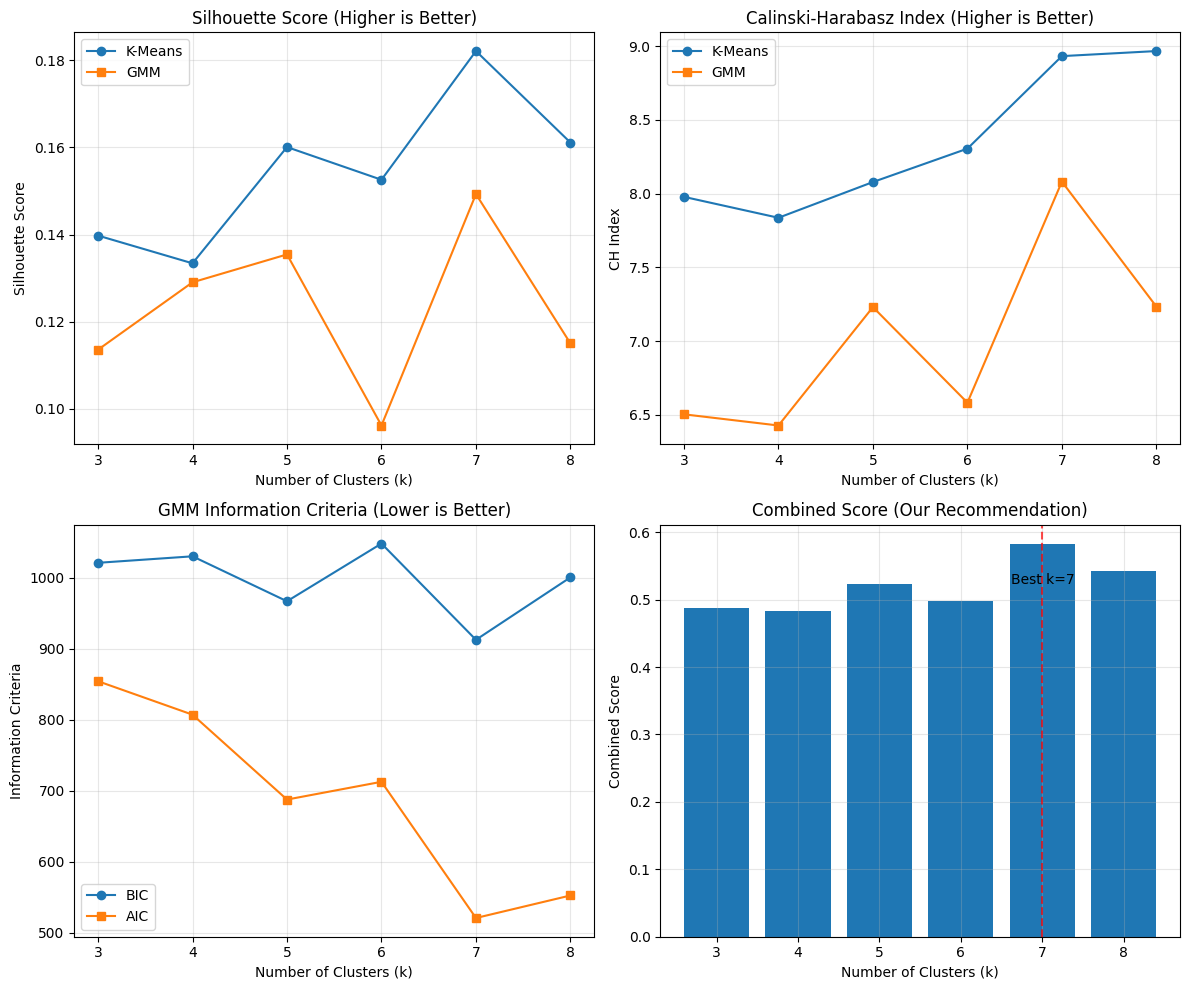



RECOMMENDATION: Use k=7 clusters

Cluster Preview (k=7):

Cluster 1: 2 champions
  JarvanIV, Nunu

Cluster 2: 21 champions
  Warwick, MonkeyKing, RekSai, MasterYi, Shaco, Pantheon, Kindred, Ekko
  ... and 13 more

Cluster 3: 7 champions
  Yorick, Udyr, Belveth, Graves, Gwen, Trundle, Diana

Cluster 4: 5 champions
  Olaf, Shyvana, DrMundo, Volibear, Vi

Cluster 5: 5 champions
  Taliyah, Rumble, Karthus, Hecarim, Talon

Cluster 6: 5 champions
  Sejuani, Ivern, Maokai, Zac, Skarner

Cluster 7: 10 champions
  Kayn, Lillia, Amumu, Zyra, Poppy, FiddleSticks, Nocturne, Gragas
  ... and 2 more

Cluster balance: 10.5x (lower is better)
⚠️  Warning: Clusters are imbalanced, consider different k

Alternatives to consider: k=[8, 5]
(Use quick_cluster_preview to examine these)

Cluster Preview (k=7):

Cluster 1: 2 champions
  JarvanIV, Nunu

Cluster 2: 21 champions
  Warwick, MonkeyKing, RekSai, MasterYi, Shaco, Pantheon, Kindred, Ekko
  ... and 13 more

Cluster 3: 7 champions
  Yorick, Udyr, Bel

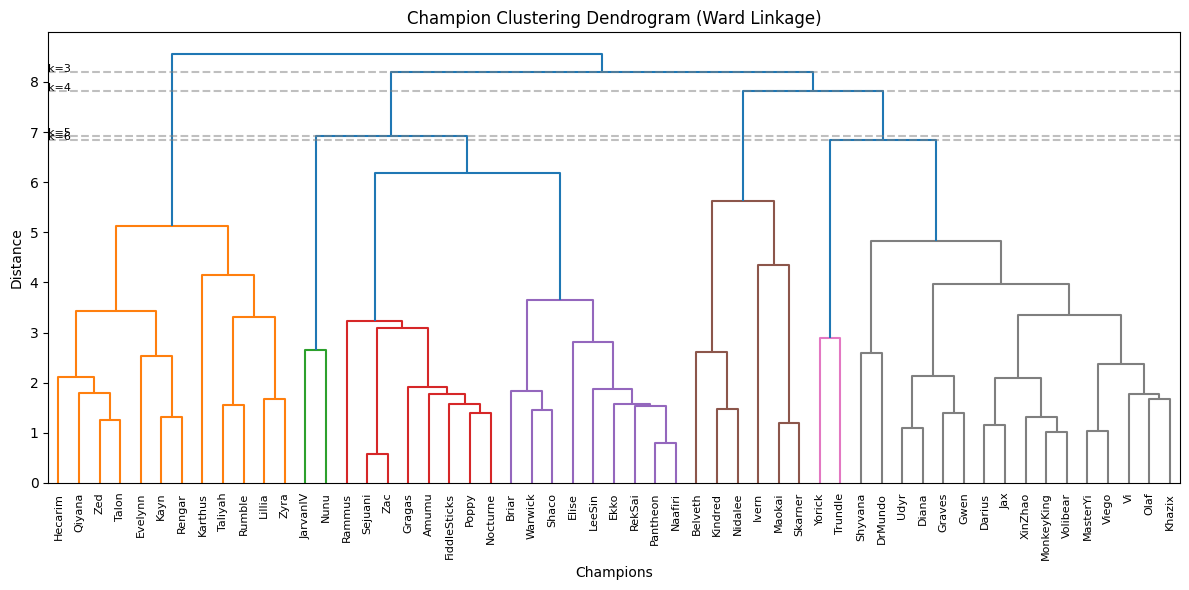


2. TESTING MULTIPLE ALGORITHMS
------------------------------

Testing k=3:
  K-Means: Silhouette=0.140, CH=8.0
  GMM: Silhouette=0.114, CH=6.5, BIC=1020.8

Testing k=4:
  K-Means: Silhouette=0.133, CH=7.8
  GMM: Silhouette=0.129, CH=6.4, BIC=1029.9

Testing k=5:
  K-Means: Silhouette=0.160, CH=8.1
  GMM: Silhouette=0.135, CH=7.2, BIC=966.7

Testing k=6:
  K-Means: Silhouette=0.153, CH=8.3
  GMM: Silhouette=0.096, CH=6.6, BIC=1047.9

Testing k=7:
  K-Means: Silhouette=0.182, CH=8.9
  GMM: Silhouette=0.149, CH=8.1, BIC=912.5

Testing k=8:
  K-Means: Silhouette=0.161, CH=9.0
  GMM: Silhouette=0.115, CH=7.2, BIC=1000.4

3. FINDING OPTIMAL K
------------------------------

Best k = 7 (highest combined score)


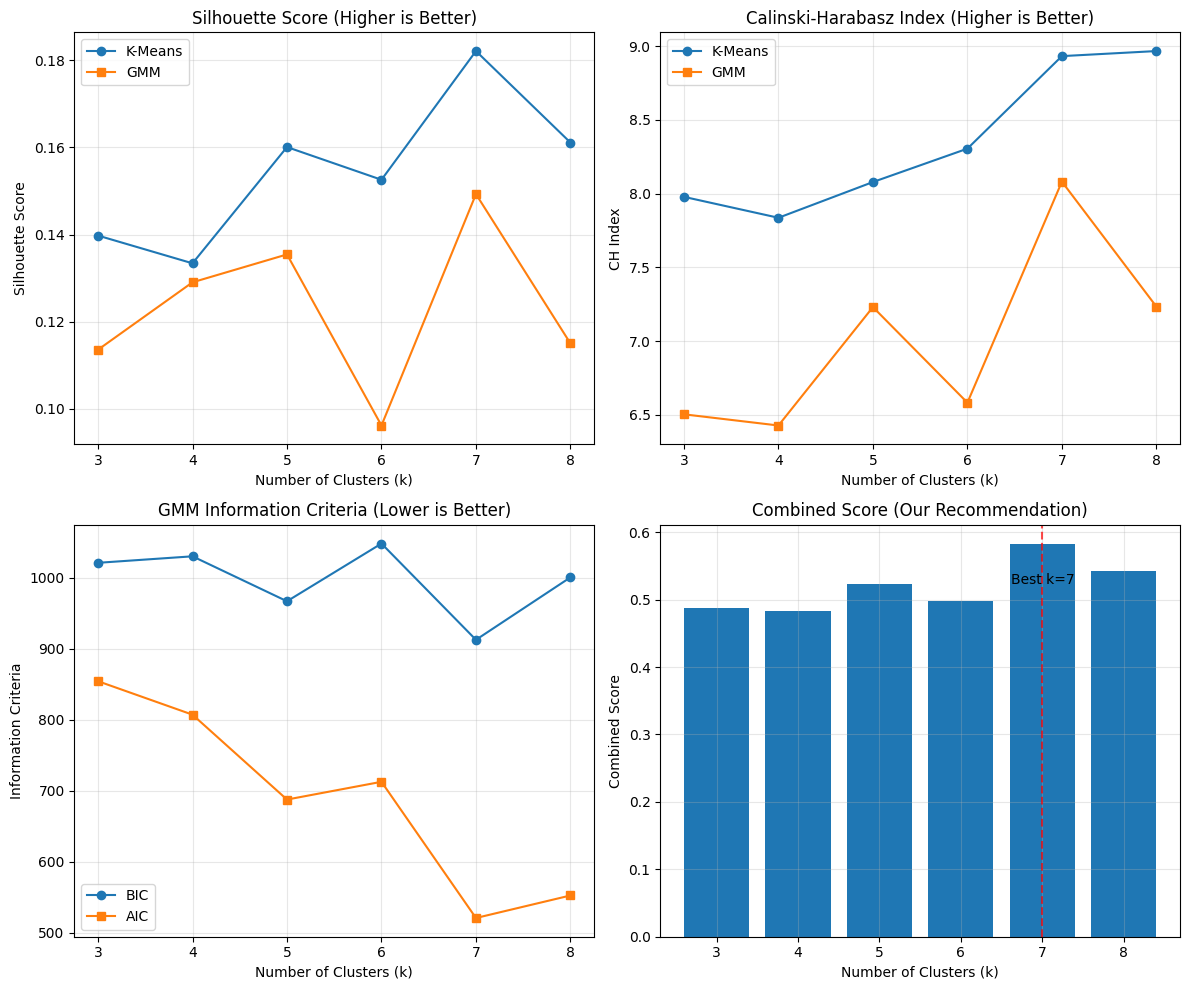



RECOMMENDATION: Use k=7 clusters

Cluster Preview (k=7):

Cluster 1: 2 champions
  JarvanIV, Nunu

Cluster 2: 21 champions
  Warwick, MonkeyKing, RekSai, MasterYi, Shaco, Pantheon, Kindred, Ekko
  ... and 13 more

Cluster 3: 7 champions
  Yorick, Udyr, Belveth, Graves, Gwen, Trundle, Diana

Cluster 4: 5 champions
  Olaf, Shyvana, DrMundo, Volibear, Vi

Cluster 5: 5 champions
  Taliyah, Rumble, Karthus, Hecarim, Talon

Cluster 6: 5 champions
  Sejuani, Ivern, Maokai, Zac, Skarner

Cluster 7: 10 champions
  Kayn, Lillia, Amumu, Zyra, Poppy, FiddleSticks, Nocturne, Gragas
  ... and 2 more

Cluster balance: 10.5x (lower is better)
⚠️  Warning: Clusters are imbalanced, consider different k

Alternatives to consider: k=[8, 5]
(Use quick_cluster_preview to examine these)

FINAL CLUSTERING (k=7)

Cluster Sizes:
  Cluster 1: 29 champions (52.7%)
  Cluster 2: 6 champions (10.9%)
  Cluster 3: 3 champions (5.5%)
  Cluster 4: 2 champions (3.6%)
  Cluster 5: 2 champions (3.6%)
  Cluster 6: 11 cham

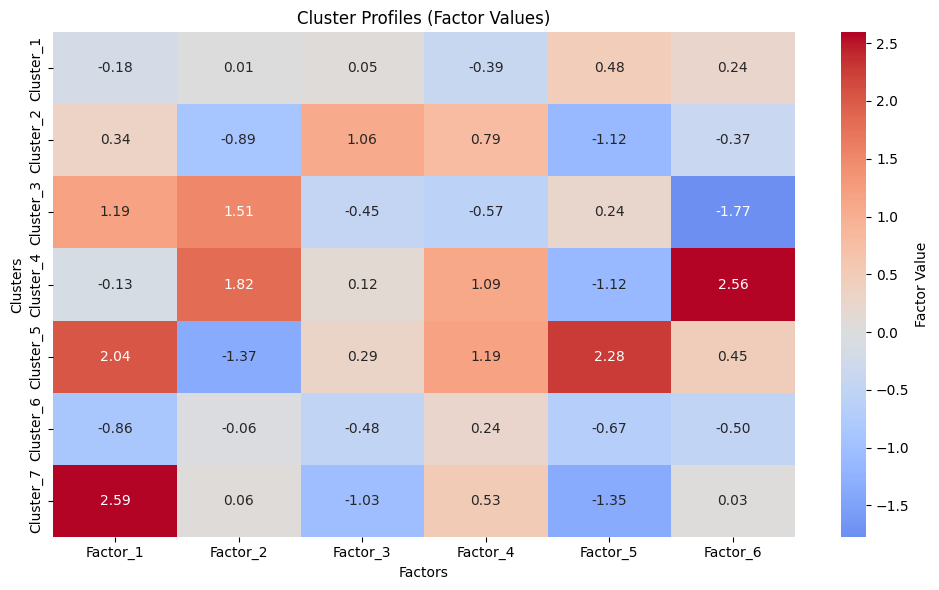

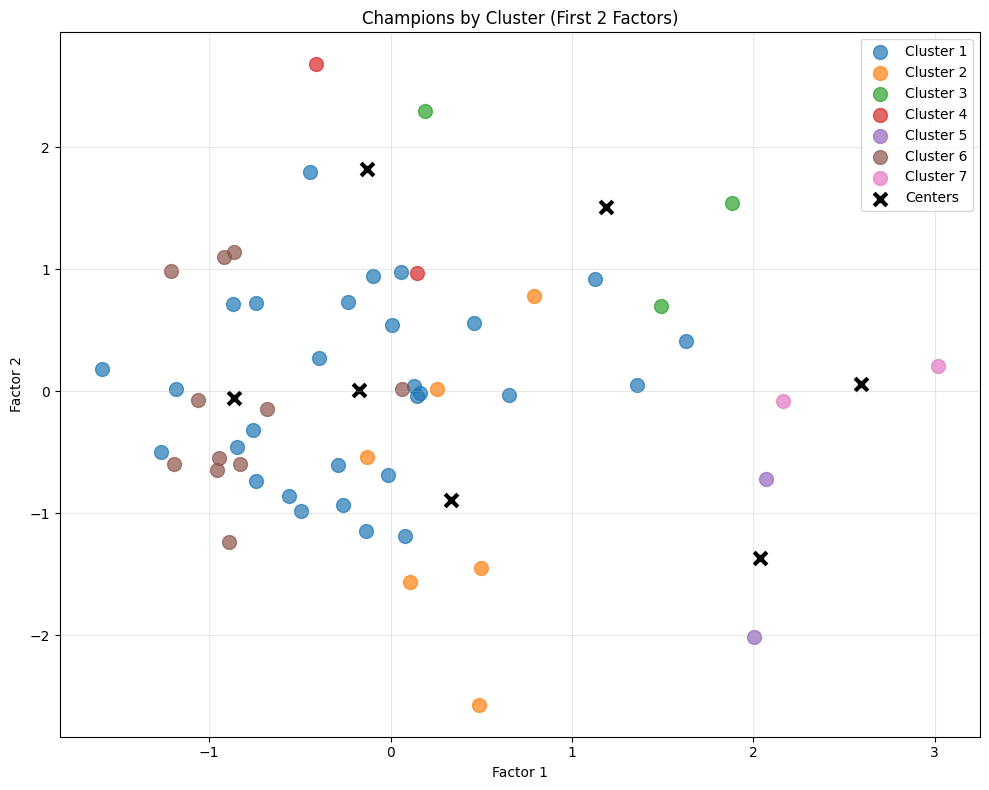


2. CLUSTER SEPARATION QUALITY
----------------------------------------
Average cluster separation: 3.71
Minimum cluster separation: 1.74
✓ Clusters are well separated

Results saved with prefix: jungle_champions
  - jungle_champions_assignments.csv
  - jungle_champions_probabilities.csv
  - jungle_champions_centers.csv
  - jungle_champions_model.pkl

CLUSTER INTERPRETATION

TOP FEATURES PER CLUSTER (% above average):
----------------------------------------

Cluster_1 (29 champions):
  avg_unreal_kills: +89.7%
  pct_of_matches_with_mana_regen: -81.3%
  avg_spell1_casts: -19.3%
  total_wins: +15.1%
  avg_multikills_after_aggressive_flash: +13.4%

Cluster_2 (6 champions):
  avg_total_magic_damage_dealt: +131.2%
  avg_unreal_kills: -100.0%
  pct_of_matches_with_mana_regen: -89.4%
  avg_spell1_casts: +70.8%
  pct_of_games_with_lanephase_gold_exp_adv: +59.3%

Cluster_3 (3 champions):
  avg_unreal_kills: -100.0%
  pct_of_matches_with_health: +78.4%
  pct_of_matches_with_mana_regen: -74.2%
 

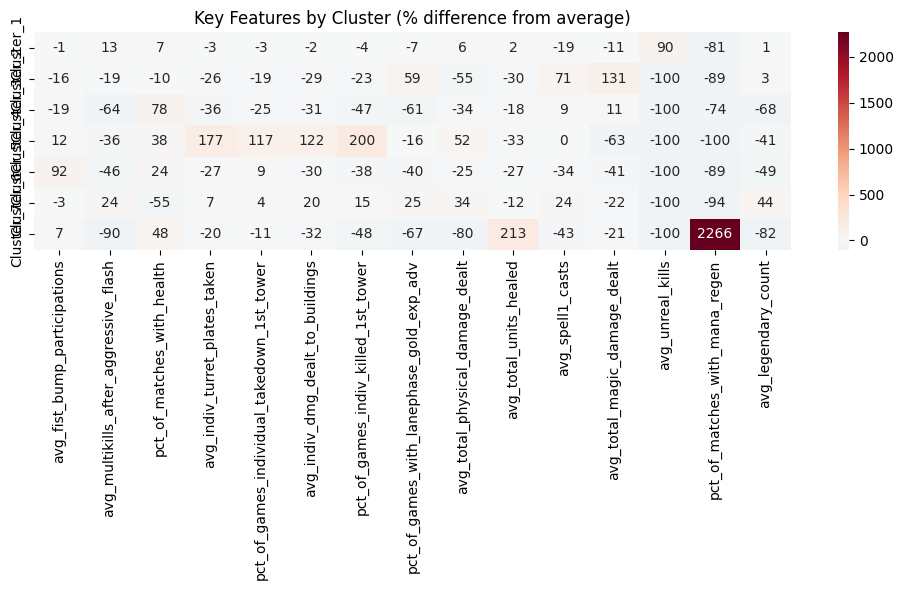


VALIDATION:
----------------------------------------
Issues found:
  ⚠️  Cluster too small (2 champions)
  ⚠️  Imbalanced clusters (largest is 14.5x bigger)

FINAL DECISION:

⚠️  REFINEMENT NEEDED

Remove these 5 features and rerun:
features_to_remove = ['avg_total_magic_damage_dealt', 'avg_total_physical_damage_dealt', 'avg_unreal_kills', 'pct_of_matches_with_ability_haste', 'pct_of_matches_with_mana_regen']

Then:
cleaned_data = original_data.drop(columns=features_to_remove)
# Restart from feature engineering with cleaned_data


SystemExit: Cleaned data insufficient

In [92]:
import sys

cleaned_jungle_data = cleaned_data
cleaned_clustering_data, ready, loadings = prepare_and_evaluate_champions(cleaned_jungle_data, n_factors=6)

if ready:
    # Run cluster exploration
    best_k, metrics = explore_optimal_clusters(cleaned_clustering_data, k_range=(3, 8))
    
    # Preview a specific k
    preview = quick_cluster_preview(cleaned_clustering_data, k=best_k)

else:
    sys.exit("Not ready")

# Continuing from exploration phase:
best_k, metrics = explore_optimal_clusters(cleaned_clustering_data)

# Perform final clustering
assignments, cluster_profiles = perform_final_clustering(
    cleaned_clustering_data,
    k=best_k,
    save_results=True,
    output_prefix='jungle_champions'
)

# After clustering is done:
is_good, features_to_remove = interpret_and_validate(
    loadings,           # saved from feature engineering step
    assignments,        # from perform_final_clustering
    cleaned_jungle_data  # your original data
)

if not is_good and features_to_remove:
    # Remove problematic features and restart
    sys.exit("Cleaned data insufficient")